### Angular Clustering in a Single Redshift Bin

In this notebook we consider Angular Clustering in a single redshift bin.

We use as a baseline scenario a redshift bin of size $\delta z = 0.2$: $\,\,\, z \in [0.4, 0.6]$.

Later we will relax this assumption and we will explore the difference between bin sizes.

###### ANGULAR POWER SPECTRA:

Using the Limber  and flat-sky approximations (valid for $\ell > 10$)  the angular power spectra of the projected field in a redshift bin $i$ can be written as: 

\begin{equation} 
C_\ell^{i} = \int_0^\infty dz \frac{H(z)}{c}\left(\frac{W^i(z)}{\chi(z)}\right)^2 P_{NL}\left(k=\frac{\ell+1/2}{\chi(z)}, z \right).
\end{equation}


###### Modeling the weighting kernel

If the overall normalized redshift distribution of a sample is $dn/dz$, the galaxy clustering weighting kernel in a redshift bin $i$ can be written as:

\begin{equation}
W^{i} = b(z)\frac{\frac{dn}{dz}F^{i}(z)}{\int_0^{\infty} \frac{dn}{dz'}F^i(z')dz'}
\end{equation}

where $b(z)$ the linear bias in the bin.

###### Assumptions

Here we will make a few simplyfing assumptions:

$\bullet$ First, we will assume that the overall redshift distribution is constant inside the bin: $dn/dz \sim$ const.
This is well justified for narrow bins.

$\bullet$ Second, we will assume that the bias is constant inside the bin: $b(z) \sim b^{i} = 1 + \bar{z}$.

$\bullet$ Furthermore we assume gaussian photo-z errors, described by one photo-z scatter and one photo-z bias parameter.

We leave free to very the cosmological parameters $\theta_c = [\Omega_{m}, \sigma_{8}]$, one galaxy bias parameter, $b_g$, and the the photo-z parameters ${\theta}_z = [\sigma_{z,0}, z_b]$.

We use as a statistic, the figure of merit between the two cosmological parameters FoM$_{\theta,c}$, but we may also consider the marginalized constraints on the individual cosmological parameters.

###### Goals / questions

We use the simple single-bin case as a starting, simple, case to studey in detail:

 - The trade-offs between redshift uncertainty and sample size.
 - How trade-offs depend on the uncertainties in these parameters ($\sigma(\sigma_z), \, \sigma(z_b)$)
 - Discuss about calibration requirements etc.
 - Discuss about bin size.
 
 We will discuss all the above in detail for the single bin case. Then, after having developed intuition, we will discuss some more particular cases for the more complicated, multiple-bin study.
 
 

In [1]:
# Import stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate 
from code.plot_utils import plot_pretty
from matplotlib import rcParams
rcParams['font.family'] = 'serif' 
%matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import the Fisher code (single bin)
from Ang_clust_SINGLE_BIN import Fish_single_bin as FSB

# Import function that calculates the Angular power spectrum in a bin
from Ang_clust_SINGLE_BIN import C_l_i as APS #this means angular power spectrum

# Import function that marginalizes over the the nuisance parameters
from Tools import marginalize as marg

# Import function that calculates the Angular power in a bin for a specific value of \ell
from Tools import C_l_specif as APS_specif

Just in case we need it, let's import CosmicFish

In [9]:
# Import CosmicFish now

import math
import sys
import os
import IPython

#=================================================================================

cosmicfish_pylib_path = '/Users/Dimitris/Desktop/Candidacy_all/Theory/CosmicFish/python'
sys.path.insert(0, os.path.normpath(cosmicfish_pylib_path))

#================================================================================
import cosmicfish_pylib.utilities            as fu
import cosmicfish_pylib.colors               as fc
import cosmicfish_pylib.fisher_matrix        as fm
import cosmicfish_pylib.fisher_derived       as fd
import cosmicfish_pylib.fisher_operations    as fo
import cosmicfish_pylib.fisher_plot_settings as fps
import cosmicfish_pylib.fisher_plot_analysis as fpa
import cosmicfish_pylib.fisher_plot          as fp

Let's summarize again the main points I want to adress in this notebook: 

- Trade-offs between sample size and photo-z uncertainty. 

In the single bin case I will assume the underlying redshift distribution is constant: $\frac{dn}{dz} \sim const$. This is approximately true for narrow bins. In that case, the constraints depend only on $N_g$ (sample size) and $\sigma_z$ (redshift uncertainty).

I want to: 

- Show trade-offs in that bin.

- Explain their origin (Signal to noise, Uncertainty in calibration)

- Explore dependence on bin size.

- Show that when bin size $\sim \sigma_z \to$ no more information

Fiducial values: $\sigma_{z} = \sigma_{z,0}(1 + z)$ and $z_b = 0.0$, $b_g = 1+ \bar{z}$.

### The origin of trade-offs 

In the first part, I want to present some plots that help us built some intuition about the origin of trade-offs/ how different factors (sample size, redshift uncertainty) compete. 

Discuss about perfect and imperfect knowledge of photo-zs.

I will define two samples in the redshift bin [0.4 - 0.6]:

- One with size $N_g = 1.1 \times 10^6$ galaxies and $\sigma_{z,0} = 0.014$. We call this "redMaGic - like" (RM) sample.
- One with size $N_g = 2.8 \times 10^7$ galaxies and $\sigma_{z,0} = 0.08$. We call this "flux limited-like" (FL) sample.

Inputs of the functions:

FSB(z_i, z_f, sig_z, z_bias, bias, f_sky, N_gal)

APS(z_i, z_f, sig_z, z_bias, bias, Omega_m_var, sig_8_var)

For future reference, error in one bin:


\begin{equation}
\delta C_\ell^i = \sqrt{\frac{2}{f_{sky}(2\ell+1)}}\left(C_\ell^i + \frac{1}{\bar{n}^i} \right)
\end{equation}

In [10]:
# Let's put here the limits and everything we are going to need for the calculations

z_i = 0.4
z_f = 0.6
z_m = 0.5*(z_i + z_f)
bias = 1.0 + z_m  #Common galaxy bias
z_bias = 0.0

sig_rm = 0.014 #Redshift error of the redMaGiC-like sample
sig_fl = 0.08 #Redshift error of the Flux limited-like sample
N_rm = 1.1e6 # Size of the redMaGiC-like sample
N_fl = 2.8e7 # Size of the flux-limited like sample
omega_m = 0.301  # Fiducial value of Omega_m
sig_8 = 0.798 # Fiducial value of sigma_8

f_sky = 4580.0/41253.0
ster = f_sky*(4.0*np.pi)

In [11]:
# A module to calculate l_max
import camb
from camb import model, initialpower

Omega_m = 0.301
sigma_8 = 0.798
h = 0.682
    
#Setting up cosmology - need to calculate chis
# Setting up cosmology
    
cosmo = camb.CAMBparams()
cosmo.set_cosmology(H0=68.2, ombh2=0.048*(h**2.0), omch2=(Omega_m - 0.048)*(h**2.0), mnu=0.06, omk=0, tau=0.06)
backres = camb.get_background(cosmo)

chi_mean = backres.comoving_radial_distance(z_m)   # comoving distance corresponding to the mean redshift of the bin
k_cutoff= 0.6*h #Cutoff scale in  Mpc^{-1}
l_max = int(round(chi_mean*k_cutoff))

print(l_max)

793


### Plots of $C_\ell$ and $\delta C_\ell$.

In [12]:
# Calculate ell and C_\ell for the RM and FL samples in that bin

ell, C_l_rm = APS(z_i, z_f, sig_rm, z_bias, bias, Omega_m, sig_8) #APS for the redMaGic sample in the bin
ell, C_l_fl = APS(z_i, z_f, sig_fl, z_bias, bias, Omega_m, sig_8) #APS for the flux limited sample in the bin

# Calculate also their errors, \delta C_\ell, using the above formula
prefact = np.sqrt(2.0/(f_sky*(2.0*ell + 1.0)))

delt_C_rm = prefact*(C_l_rm + (ster/N_rm))
delt_C_fl = prefact*(C_l_fl + (ster/N_fl))

A plot that I can make is the one that shows $C_\ell, \,\, \delta C_\ell$, and their ratio.

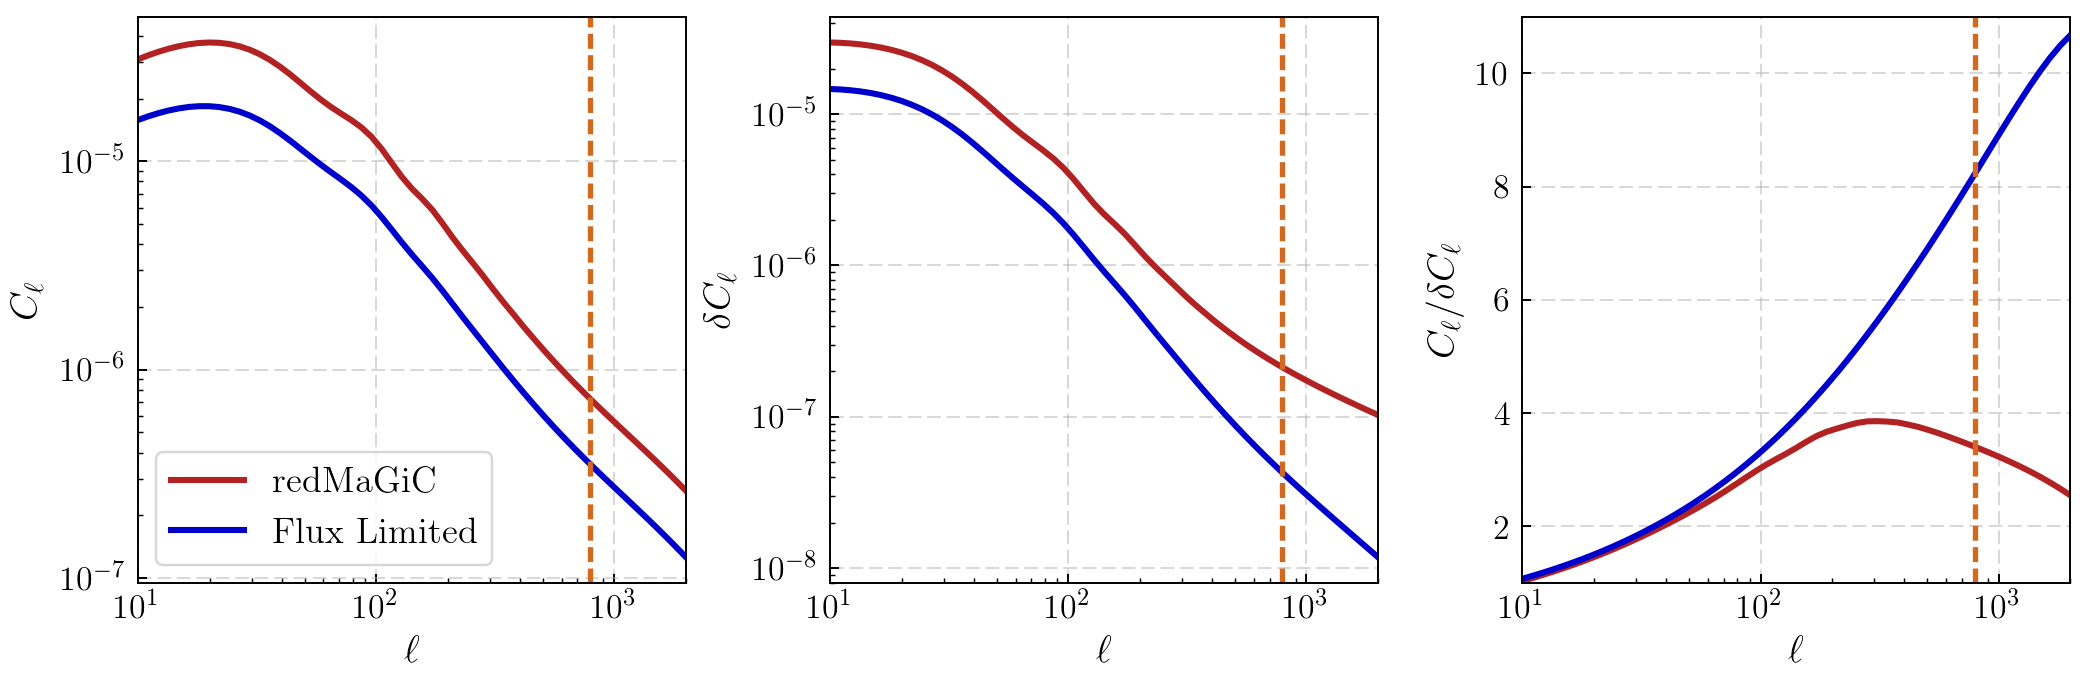

In [13]:
plot_pretty()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (12.0,4.0))

ax[0].plot(ell,C_l_rm, c='firebrick', linewidth=2.5, label='redMaGiC' )
ax[0].plot(ell,C_l_fl, c='mediumblue', linewidth=2.5, label='Flux Limited')
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlim(10.0,2000.0)
ax[0].set_xlabel(r'$\ell$',fontsize=16);ax[0].set_ylabel('$C_\ell$', fontsize=16)
ax[0].axes.tick_params(axis='both', labelsize=14)
ax[0].legend(frameon=True, loc='lower left', fontsize=15)
ax[0].grid(ls='--', alpha=0.5)
ax[0].axvline(x=l_max, color='chocolate', ls ='--', linewidth=2.2)

#===============================================================================================

ax[1].plot(ell, delt_C_rm, c='firebrick', linewidth=2.5)
ax[1].plot(ell,delt_C_fl, c='mediumblue', linewidth=2.5)
ax[1].set_xscale('log');ax[1].set_yscale('log')
ax[1].set_xlim(10.0,2000.0)#
ax[1].set_xlabel('$\ell$',fontsize=16);ax[1].set_ylabel('$\delta C_\ell$', fontsize=16)
ax[1].axes.tick_params(axis='both', labelsize=14)
ax[1].grid(ls='--', alpha=0.5)
ax[1].axvline(x=l_max, color='chocolate', ls='--', linewidth=2.2)
#=============================================================================

ax[2].plot(ell, C_l_rm/delt_C_rm, c='firebrick', linewidth=2.5)
ax[2].plot(ell, C_l_fl/delt_C_fl, c='mediumblue', linewidth=2.5)
ax[2].set_xscale('log')#;ax[1].set_yscale('log')
ax[2].set_xlim(10.0,2000.0),ax[2].set_ylim(1.0,11.0)
ax[2].set_xlabel('$\ell$',fontsize=16);ax[2].set_ylabel('$C_\ell/\delta C_\ell$', fontsize=16)
ax[2].axes.tick_params(axis='both', labelsize=14)
ax[2].grid(ls='--', alpha=0.5)
ax[2].axvline(x=l_max, color='chocolate', ls='--', linewidth= 2.2)

plt.tight_layout()
#plt.savefig('C_l_delt_l.pdf')
plt.show()

Or I can show just the last one:

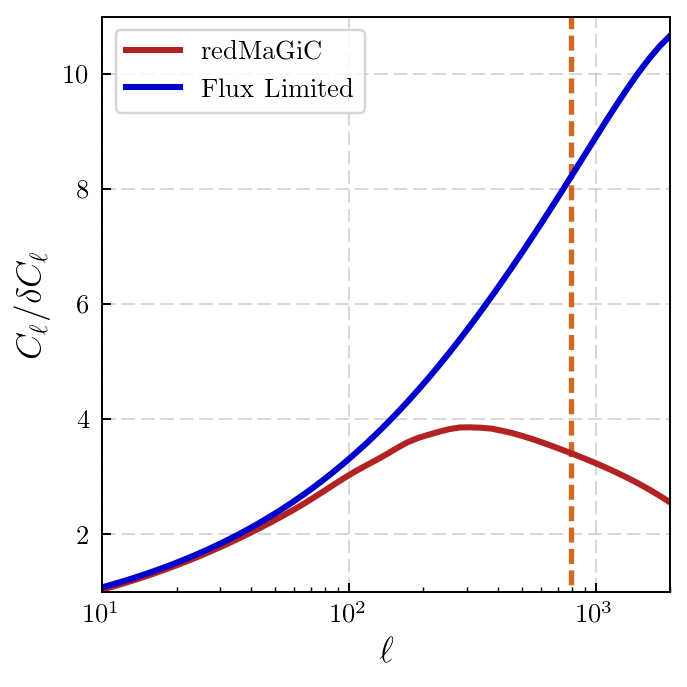

In [14]:
fig = plt.figure(figsize = (4.0,4.0))

plt.plot(ell,C_l_rm/delt_C_rm, c='firebrick', linewidth=2.5,label='redMaGiC')
plt.plot(ell,C_l_fl/delt_C_fl, c='mediumblue',linewidth=2.5,label='Flux Limited')
plt.xscale('log')#;plt.yscale('log')
plt.xlim(10.0,2000.0);plt.ylim(1.0,11)

plt.ylabel('$C_\ell/\delta C_\ell$',fontsize=15)
plt.xlabel('$\ell$',fontsize=15)
plt.grid(ls='--', alpha=0.5)
plt.legend(frameon=True, loc='upper left', fontsize=11)
plt.tick_params(axis='both', labelsize=11)
plt.vlines(l_max,0,11, color='chocolate', linestyle='--', linewidth= 2.2)

plt.tight_layout()
plt.savefig('ratio.pdf')
plt.show()

Width of the bin. I will plot the ratio:  $\frac{C_\ell^{RM}}{C_\ell^{FL}}$, at $\ell = 200$ as a function of the bin size (always centered at $ z = 0.5$).

In [15]:
delta_z = np.linspace(0.05,0.40,50)
z_i_tem = 0.5 - delta_z/2.0
z_f_tem = 0.5 + delta_z/2.0
ell = 200

C_200_rm = np.zeros(50); C_200_fl = np.zeros(50)

for i in range(50):
    C_200_rm[i] = APS_specif(z_i_tem[i], z_f_tem[i], sig_rm, z_bias, bias, Omega_m, sig_8, ell) #RedMaGiC
    C_200_fl[i] = APS_specif(z_i_tem[i], z_f_tem[i], sig_fl, z_bias, bias, Omega_m, sig_8, ell) #Flux Limited

ratio_RM_FL = C_200_rm/C_200_fl

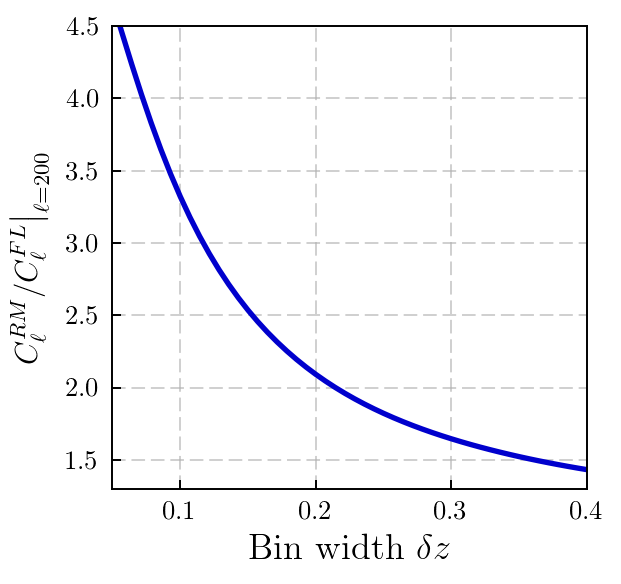

In [16]:
fig = plt.figure(figsize = (3.5,3.5))

plt.plot(delta_z, ratio_RM_FL, color='mediumblue', linewidth=2.2)
plt.grid(ls='--', alpha=0.6)

plt.tick_params(axis='both', labelsize=11)

plt.xlabel('Bin width $\delta z$', fontsize=15)
plt.ylabel(r'$\left. C_\ell^{RM}/C_\ell^{FL} \right|_{\ell = 200}$', fontsize =13)
plt.xlim(0.05,0.40);plt.ylim(1.3,4.5)


plt.show()

### Effect of uncertainty in the photo-z parameters

In the above we assumed a perferct knowledge of the photo-z parameters $\sigma_{z,0}$ and $z_b$. 
In practice we have to introduce uncertainties in these parameters, call them $\Delta \sigma_{z}$ and $\Delta z_b$. 

The key challenge to use of photo-z's in cosmological inference is the validation of the resulting redshift distribution, in other words the assignment of meaningful error distributions to the redshift errors.

A very simple model for the uncertainties is the following: If the calibration (spectroscopic) sample has size $N_{spec}$, the errors in the photo-z parameters are:

\begin{equation}
\Delta z_{bias} = \frac{\sigma_z}{\sqrt{N_{spec}}}
\end{equation}

and 

\begin{equation}
\Delta \sigma_z = \frac{\sigma_z}{\sqrt{N_{spec}/2}}
\end{equation}

So, here we want to see how uncertainties in the photo-z parameters translate into uncertainties in cosmology.


###### First plot: Show how $C_\ell$ changes with different cosmologies and different photo-z errors.

Here I want to show that uncertainty in the photo-z parameters translates to uncertainties in the Cosmological parameter inference.

To do so, I will plot the ratio $(C_\ell - C^0_\ell)/C_\ell^0$ where $C_\ell$ is the angular power spectrum for different values of $\Omega_m$ or $\sigma_8$ or different photo-z parameters and $C_\ell^0$ the APS with the fiducial parameters.

I will use values $\delta z_b = 0.01$ and $\delta \sigma_z = 0.01$



In [17]:
ell, C_ell_fid = APS(z_i, z_f, sig_fl, z_bias, bias, Omega_m, sig_8)
ell, C_ell_high_Om = APS(z_i, z_f, sig_fl, z_bias, bias, Omega_m+2, sig_8)
ell, C_ell_low_Om = APS(z_i, z_f, sig_fl, z_bias, bias, Omega_m-2, sig_8)
ell, C_ell_high_red = APS(z_i, z_f, sig_fl+0.013, z_bias+0.013, bias, Omega_m, sig_8)
ell, C_ell_low_red = APS(z_i, z_f, sig_fl-0.013, z_bias-0.013, bias, Omega_m, sig_8)
ell, C_ell_high_s_8 = APS(z_i, z_f, sig_fl, z_bias, bias, Omega_m, sig_8+2)
ell, C_ell_low_s_8 = APS(z_i, z_f, sig_fl, z_bias, bias, Omega_m, sig_8-2)

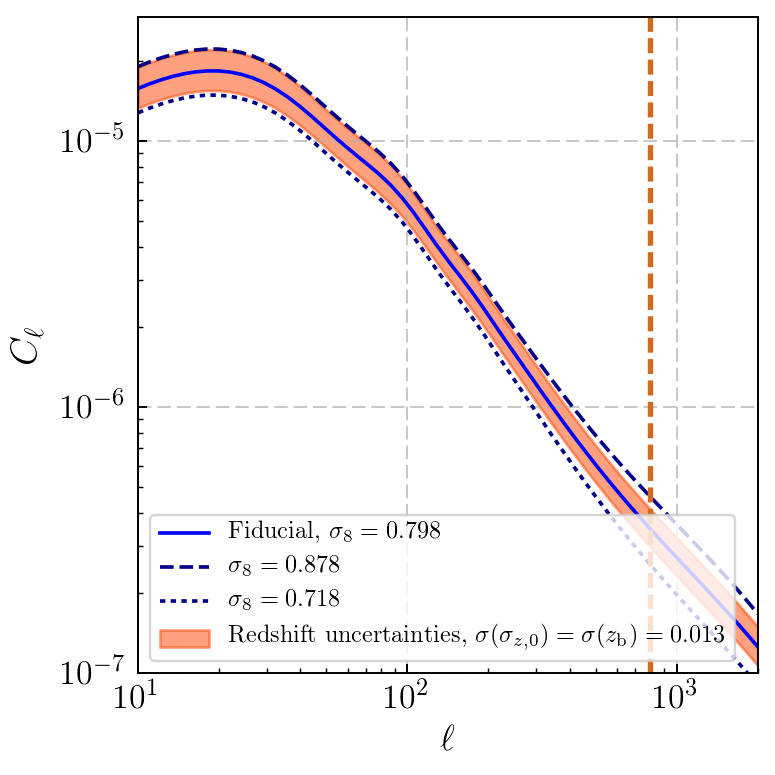

In [18]:
fig = plt.figure(figsize = (4.5,4.5))

plt.plot(ell, C_ell_fid, c='blue', label=r'Fiducial, $\sigma_8 = 0.798')
plt.plot(ell, C_ell_high_s_8, c='darkblue', ls='--', label='$\sigma_8 = 0.878$')
plt.plot(ell, C_ell_low_s_8, c='darkblue', ls=':', label='$\sigma_8 = 0.718$')
#plt.plot(ell, C_ell_high_s_8, c='darkred', ls='-.', label='Higher $\sigma_8$')
#plt.plot(ell, C_ell_low_s_8, c='darkred', ls='-.', label='Lower $\sigma_8$')
plt.fill_between(ell, C_ell_high_red, C_ell_low_red,  color = 'orangered',  alpha=0.5, linewidth=1.1, label='Redshift uncertainties, $\sigma(\sigma_{z,0}) = \sigma(z_{\mbox{\scriptsize{b}}}) = 0.013$')
#plt.plot(ell, C_ell_low_red, c='orangered', ls='--', linewidth=1.1)
#plt.vlines(l_max,0,11, color='chocolate', linestyle='--', linewidth= 2.2)
plt.axvline(x=l_max, color='chocolate', ls='--', linewidth= 2.2)
plt.grid(ls='--', alpha=0.7)
plt.xscale('log');plt.yscale('log')
plt.xlim(10.0,2000);plt.ylim(1e-7,)

plt.ylabel('$C_\ell$',fontsize=16)
plt.xlabel('$\ell$',fontsize=15)
plt.tick_params(axis='both', labelsize=14)

plt.legend(frameon=True, loc='lower left', fontsize=10)
plt.tight_layout()
plt.savefig('Red_uncert.pdf')
plt.show()

Or I can just plot the differences from the baseline scenario

In [19]:
diff_high_Om = (C_ell_high_Om - C_ell_fid)/C_ell_fid
diff_low_Om = (C_ell_low_Om - C_ell_fid)/C_ell_fid
diff_high_red = (C_ell_high_red - C_ell_fid)/C_ell_fid
diff_low_red = (C_ell_low_red - C_ell_fid)/C_ell_fid
diff_high_s_8 = (C_ell_high_s_8 - C_ell_fid)/C_ell_fid
diff_low_s_8 = (C_ell_low_s_8 - C_ell_fid)/C_ell_fid

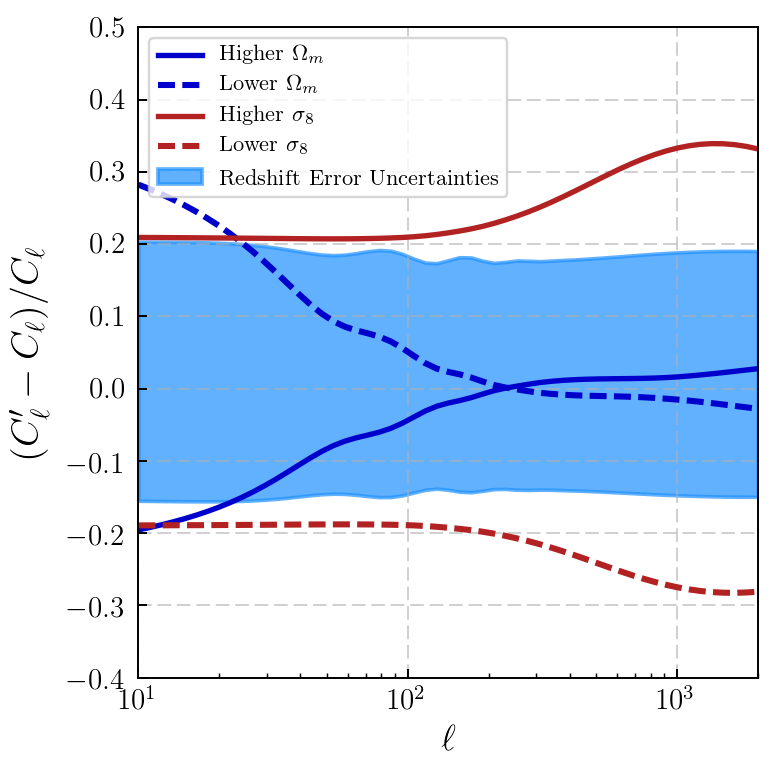

In [20]:
fig = plt.figure(figsize = (4.5,4.5))

plt.plot(ell, diff_high_Om, c='mediumblue', linewidth=2.2, label='Higher $\Omega_m$')
plt.plot(ell, diff_low_Om, c='mediumblue', ls='--', linewidth=2.5, label='Lower $\Omega_m$')
#plt.plot(ell, diff_high_red, c='firebrick', linewidth=2.2, label)
#plt.plot(ell, diff_low_red, c='firebrick', ls='--', linewidth=2.5)

plt.fill_between(ell, diff_high_red, diff_low_red, color='dodgerblue',linewidth=1.5, alpha=0.7, label='Redshift Error Uncertainties')
plt.plot(ell, diff_high_s_8, c='firebrick', linewidth=2.2, label='Higher $\sigma_8$')
plt.plot(ell, diff_low_s_8, c='firebrick', ls='--', linewidth=2.5, label='Lower $\sigma_8$')

plt.grid(ls='--', alpha=0.6)
plt.ylabel('$(C_\ell^{\prime}-C_\ell)/C_\ell$',fontsize=16)
plt.xlabel('$\ell$',fontsize=15)
plt.tick_params(axis='both', labelsize=12)

plt.xlim(10,2000);plt.ylim(-0.4,0.5)
plt.xscale('log')

plt.legend(frameon=True, loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('differences.pdf')
plt.show()

### Figure of Merit plots 

Now that we have demonstrated that both the redshift errors and the redshift error parameters can affect the measurement of cosmlogical parameters, let's try to quantify this, using as a measure the Figure of Merit (FoM) for the constraints on the two cosmological parameters $\Omega_m$ and $\sigma_8$.

I will start by making two (contour) plots. Figure of merit as a function of redshift uncertainty ($\sigma_{z,0}$) and sample size, $N_g$, for two cases: Redshift uncertainties fixed to their fiducial values and redshift uncertainties free to vary, without any prior.

In [21]:
# Array of sample sizes and redshift errors
#N_gal_lin = np.linspace(5.0, np.log10(3.0e7),35)
#N_gal_arr = 10.0**N_gal_lin
N_gal_arr = np.linspace(1.0e5, 3.0e7, 35)
sig_z_arr = np.linspace(0.01, 0.1, 35)
size = np.size(N_gal_arr)

In [22]:
# Figure of Merit - fixed redshift errors - in other words, very conservative priors
#======================================================================
# Initialize matrix
FoM_fix = np.zeros([size,size])

for i in range(size):
    sig_z = sig_z_arr[i]
    for j in range(size):
        N_gal = N_gal_arr[j]
        
        #Calculate the Fisher matrix now
        Fish_mat = FSB(z_i,z_f,sig_z,z_bias,bias,f_sky,N_gal)
        
        #Add the priors - let them be common 
        inv_sig_sq_prior = 1e20
        Fish_mat[3,3] = Fish_mat[3,3] + inv_sig_sq_prior
        Fish_mat[4,4] = Fish_mat[4,4] + inv_sig_sq_prior
        
        #Marginalize over the nuisance parameters now
        Fish_marg = marg(Fish_mat)
        
        FoM_fix[i][j] = np.sqrt(np.linalg.det(Fish_marg))

In [23]:
# Figure of Merit - free to vary redshift errors - without any priors
# =================================================================
FoM_free = np.zeros([size,size])

for i in range(size):
    sig_z = sig_z_arr[i]
    for j in range(size):
        N_gal = N_gal_arr[j]
        
        # Calculate the Fisher matrix now
        Fish_mat = FSB(z_i,z_f,sig_z,z_bias,bias,f_sky,N_gal)
        
        #Marginalize over the nuisance parameters now
        Fish_marg = marg(Fish_mat)
        
        FoM_free[i][j] = np.sqrt(np.linalg.det(Fish_marg))

In [24]:
# Calculate the Figure of Merit for the redMaGic-like sample in the two cases
# ============================================================================

# Free redshift errors
Fish_rm_Free = FSB(z_i,z_f, sig_rm, z_bias, bias, f_sky, N_rm)

# Marginalize

Fish_rm_free_marg = marg(Fish_rm_Free)
FoM_rm_free = np.sqrt(np.linalg.det(Fish_rm_free_marg))


#Fixed redshift errors
inv_sig_sq_prior = 1e20

Fish_rm_fix = Fish_rm_Free
Fish_rm_fix[3,3] = Fish_rm_fix[3,3] + inv_sig_sq_prior
Fish_rm_fix[4,4] = Fish_rm_fix[4,4] + inv_sig_sq_prior

Fish_rm_fix_marg = marg(Fish_rm_fix)
FoM_rm_fix = np.sqrt(np.linalg.det(Fish_rm_fix_marg))

print(FoM_rm_fix/FoM_rm_free)

29.8248699100221


In [25]:
# Normalize the two matrices now 
# =================================================
# Fixed redshift errors case
FoM_fix_tr = np.matrix.transpose(FoM_fix)
FoM_fix_norm = FoM_fix_tr/(FoM_rm_fix)

# Free redshift errors case
FoM_free_tr = np.matrix.transpose(FoM_free)
FoM_free_norm = FoM_free_tr/(FoM_rm_free)

Let's plot them now.
First the fixed photo-z error case.

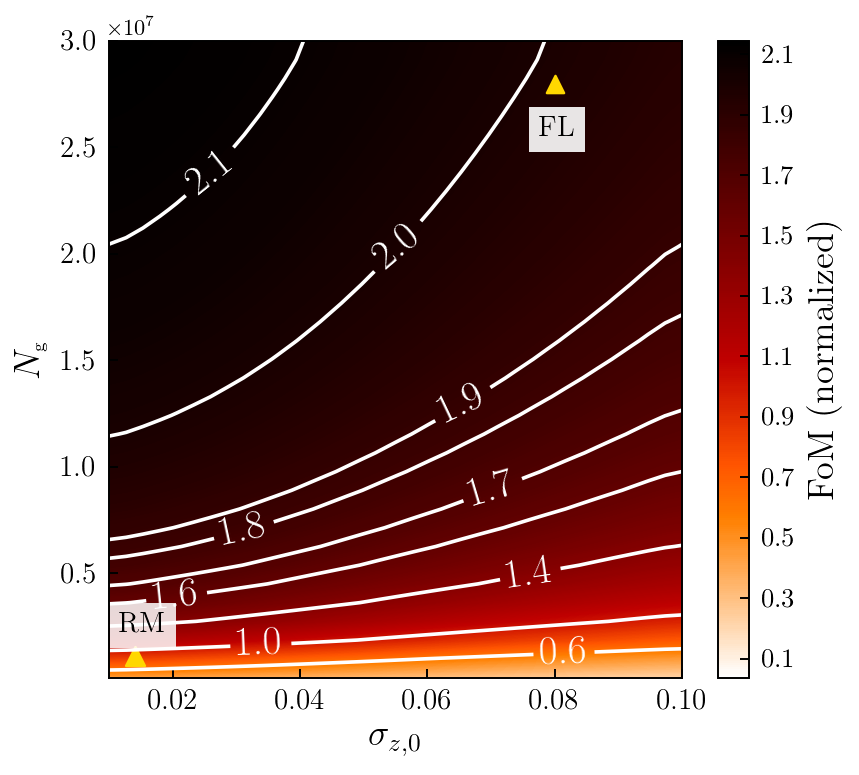

In [26]:
import scipy.ndimage
def FoM_fixed_return(a_1,a_2):
    FoMino = FoM_fix_norm
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_pr = FoM_fixed_return(a_1, a_2)

FoM_pr = scipy.ndimage.gaussian_filter(FoM_pr, 1)
levels = np.linspace(np.min(FoM_fix_norm),np.max(FoM_fix_norm),300)
image = plt.contourf(a_1, a_2, FoM_pr , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr, [0.6,1.0,1.4, 1.6,1.7,1.8, 1.85,2.0,2.1,2.2] , colors=('w','w', 'w', 'w', 'w','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.0)
plt.clabel(C, inline=1, fontsize=17, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(0.08,2.8e7, color='gold', s=50.0, marker='^')

plt.text(0.0775, 2.55e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.014,1.1e6, color='gold', s=60.0, marker='^')
plt.text(0.0116, 2.2e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=12)

plt.xlabel("$\sigma_{z,0}$", fontsize=15);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=15)


plt.xlim(0.01,0.1);plt.ylim(1.0e5, 3.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1], fontsize=11)

plt.tight_layout()
plt.savefig('FoM_single_bin_fixed.pdf')
plt.show() 


And the free photo-z error case now

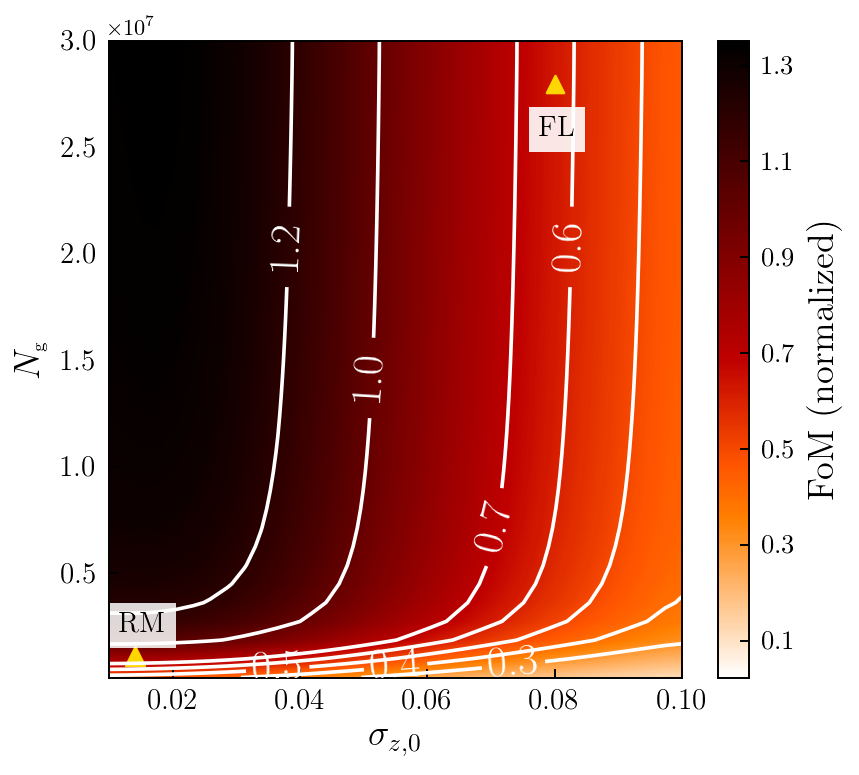

In [27]:
import scipy.ndimage
def FoM_free_return(a_1,a_2):
    FoMino = FoM_free_norm
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_pr = FoM_free_return(a_1, a_2)

FoM_pr = scipy.ndimage.gaussian_filter(FoM_pr, 1)
levels = np.linspace(np.min(FoM_free_norm),np.max(FoM_free_norm),300)
image = plt.contourf(a_1, a_2, FoM_pr , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr, [0.3,0.4,0.5,0.6, 0.7,1.0,1.2, 1.5,1.8,2.1,2.2] , colors=('w','w', 'w', 'w', 'w','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.0)
plt.clabel(C, inline=2, fontsize=18, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(0.08,2.8e7, color='gold', s=50.0, marker='^')

plt.text(0.0775, 2.55e7,'FL', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.014,1.1e6, color='gold', s=60.0, marker='^')
plt.text(0.0116, 2.2e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=12)

plt.xlabel("$\sigma_{z,0}$", fontsize=15);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=15)


plt.xlim(0.01,0.1);plt.ylim(1.0e5, 3.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1], fontsize=11)

plt.tight_layout()
#plt.savefig('FoM_single_bin_free.pdf')
plt.show() 



In [28]:
# Calculate the Figure of Merit for the flux-limited-like sample in the two cases
# ===========================================================================

# Free redshift errors
Fish_fl_Free = FSB(z_i,z_f, sig_fl, z_bias, bias, f_sky, N_fl)

# Marginalize

Fish_fl_free_marg = marg(Fish_fl_Free)
FoM_fl_free = np.sqrt(np.linalg.det(Fish_fl_free_marg))


#Fixed redshift errors
inv_sig_sq_prior = 1e20

Fish_fl_fix = Fish_fl_Free
Fish_fl_fix[3,3] = Fish_fl_fix[3,3] + inv_sig_sq_prior
Fish_fl_fix[4,4] = Fish_fl_fix[4,4] + inv_sig_sq_prior

Fish_fl_fix_marg = marg(Fish_fl_fix)
FoM_fl_fix = np.sqrt(np.linalg.det(Fish_fl_fix_marg))

I want now to calculate the ratio:

\begin{equation}
\frac{\mbox{FoM}_{FL}}{\mbox{FoM}_{RM}}
\end{equation}

In the two cases (photo-z errors free and photo-z errors fixed).

In [29]:
rat_fixed = FoM_fl_fix/FoM_rm_fix
rat_free = FoM_fl_free/FoM_rm_free 
print("Ratio in the fixed photo-z errors case:", rat_fixed)
print("Ratio in the free photo-z errors case:", rat_free)

('Ratio in the fixed photo-z errors case:', 1.9851094165734389)
('Ratio in the free photo-z errors case:', 0.6309680275916265)


However the above are two extreme cases. In practice we will have neither perfect knowlede nor complete ignorance of the photo-z errors. 

Let's make a similar (to the above) plot, but use some realistic priors.

Let's consider again the above model for photo-z priors:


\begin{equation}
\Delta z_{bias} = \frac{\sigma_z}{\sqrt{N_{spec}}}
\end{equation}

and 

\begin{equation}
\Delta \sigma_z = \frac{\sigma_z}{\sqrt{N_{spec}/2}}
\end{equation}

### Some numbers

Let's try to find some numbers to use in this case here.


In arXiv 1601.05779, we find the following priors for the photo-z error parameters ${\mathbf{LSST}}$:
###### Lens photo-z (red sequence) 
\begin{equation}
\Delta_{z,lens}^i = 0.0, \quad \sigma(\Delta_{z,lens}^i) = 0.0004\\
\sigma_{z,lens} = 0.01, \quad \sigma(\sigma_{z,lens}) = 0.0006
\end{equation}

###### Source photo-z 
\begin{equation}
\Delta_{z,source}^i = 0.0, \quad \sigma(\Delta_{z,source}^i) = 0.002\\
\sigma_{z,source} = 0.05, \quad  \sigma(\sigma_{z,source}) = 0.003
\end{equation}


#### Numbers from DES papers

From Cawthon et al. arXiv: 1809.09251

Dependence on redshift priors 

Calibration on redshift parameters. Level of prior on quantities like $z_0$ and $\sigma_z$.

LSST target for redshift priors on galaxy samples:

LSS measurements 10-year analysis target
\begin{equation}
\sigma(\Delta z_b) \sim 0.003(1+z)\\
\sigma(\sigma_z) \sim 0.03(1+z)
\end{equation}

Weak Lensing sources
\begin{equation}
\sigma(\Delta z_b) \sim 0.003(1+z)\\
\sigma(\sigma_z) \sim 0.03(1+z)
\end{equation}

Spatial cross-correlation of photometric and spectroscopic galaxies $\sigma(\Delta z_b) \sim \sigma(\sigma_z) \sim 0.0004(1+z)$.

DES redshift parameter priors of the order $\sim 0.01 - 0.02$. redMaGiC $\to$ tighter constraints.


##### Some more notes about DES treatment of photometric redshifts.

The above modeling of photometric redshifts, with a bias parameter $z_b$ and a spread $\sigma_z$ is widely used in the forecasting literature / when modeling of the photo-z uncertainties is needed. In practice, cosmological surveys like DES use a different method to take into account the photo-z uncertainties. 

Using the photo-z codes, an estimation of the galaxy redshift distribution is calcualated, $n_g^i(z)$. Potential biases in the estimation of the galaxy redshift distributions are modeled using a single additive bias parameter for each redshift bin:

\begin{equation}
n_{g,unbiased}^i(z) = n_g^i(z - \Delta_{z,g}^i)
\end{equation}

Note that in general (I will explore this later) $\Delta_{z,g} \neq z_b$.

Here I will use some numbers for the error on $\Delta_{z,g}^i$ quoted in DES papers.


Notes from arXiv: 1810.02342

Lens bins: $[0.15-0.3],[0.3-0.45],[0.45-0.6],[0.6-0.75],[0.75-0.9]$.

\begin{equation}
\Delta_{z,g}^1 = \quad 0.01 \pm 0.007\\
\Delta_{z,g}^2 = -\quad 0.004 \pm 0.007\\
\Delta_{z,g}^3 = \quad 0.009 \pm 0.006\\
\Delta_{z,g}^4 = \quad 0.001 \pm 0.01\\
\Delta_{z,g}^5 = \quad 0.0 \pm 0.01\\
\end{equation}

Notes from 1810.02322 
Source bins: $[0.2-0.43],[0.43-0.63],[0.63-0.9],[0.9-1.3]$.

\begin{equation}
\Delta_{z,s}^1 = \quad - 0.001 \pm 0.016 \\
\Delta_{z,s}^2 = \quad -0.019 \pm 0.013 \\
\Delta_{z,s}^3 = \quad 0.009 \pm 0.011 \\
\Delta_{z,s}^4 = \quad -0.018 \pm 0.022
\end{equation}


Here I will consider $\sigma(z_b) \sim \sigma(\sigma_z) = \alpha \sigma_z$, motivated by the simple model described above. What is $\alpha$?

Adopting the numbers in the Krause et al paper I calculate: 

$\alpha \sim 0.04$. I will adopt this as a model, but I will explore other cases as well.

Note the relationship (that I claim is true, I have to further investivgate this later) between the errors in $\Delta_{z,g}^i$ (the shift in redshift distributions) and the gaussian photo-z biass $z_b^i$:

\begin{equation} 
\delta \Delta_{z,g} \sim \frac{\delta z_{b}}{\sqrt{2}\sigma_z} \Leftrightarrow \delta z_b \sim \sqrt{2}\delta \Delta_{z,g} \sigma_z
\end{equation}

#### One more contour plot with a reasonable prior

Now, I will make one more contour plot, similar to those presented above but adopting a reasonable prior. 

The adopted prior has the form:

\begin{equation}
\sigma(z_b) = \sigma(\sigma_z) = \alpha \sigma_z = \alpha \sigma_{z,0} (1 +\bar{z})
\end{equation}


\begin{equation}
\sigma(z_b) = \sigma(\sigma_z) = 0.01 \times\sigma_{z,0}
\end{equation}

In [30]:
# Figure of Merit contour plot with the "reasonable" prior described above
#======================================================================
# Initialize matrix
FoM_prior = np.zeros([size,size])

for i in range(size):
    sig_z = sig_z_arr[i]
    for j in range(size):
        N_gal = N_gal_arr[j]
        
        #Calculate the Fisher matrix now -without any prior
        Fish_mat = FSB(z_i,z_f,sig_z,z_bias,bias,f_sky,N_gal)
        
        #Calculate the common prior now
        prior = 0.2*sig_z
        
        inv_sig_sq_prior = 1.0/(prior**2.0)
        
        Fish_mat[3,3] = Fish_mat[3,3] + inv_sig_sq_prior
        Fish_mat[4,4] = Fish_mat[4,4] + inv_sig_sq_prior
        
        #Marginalize over the nuisance parameters now
        Fish_marg = marg(Fish_mat)
        
        FoM_prior[i][j] = np.sqrt(np.linalg.det(Fish_marg))

In [31]:
# Calculate the FoM for the redMaGiC and Flux limited samples using the same prior as the one described above
# =========================================================================================================
# =========================================================================================================

# Free Fisher matrix - no redshift errors for redMaGiC
Fish_rm_Free = FSB(z_i,z_f, sig_rm, z_bias, bias, f_sky, N_rm)
# Free Fisher matrix - no redshift errors for flux limited
Fish_fl_Free = FSB(z_i,z_f, sig_fl, z_bias, bias, f_sky, N_fl)

# Priors for the two samples
prior_rm = 0.2*sig_rm  # Prior for the redmagic sample
prior_fl = 0.2*sig_fl  # Prior for the flux limited sample

#inverses
inv_rm_prior = 1.0/(prior_rm**2.0)
inv_fl_prior = 1.0/(prior_fl**2.0)

# Add the priors now
# ==========================================================================================================

# For redMaGiC
Fish_rm_prior = np.copy(Fish_rm_Free) 
Fish_rm_prior[3,3] = Fish_rm_prior[3,3] + inv_rm_prior
Fish_rm_prior[4,4] = Fish_rm_prior[4,4] + inv_rm_prior

# For flux limited
Fish_fl_prior = np.copy(Fish_fl_Free) 
Fish_fl_prior[3,3] = Fish_fl_prior[3,3] + inv_fl_prior
Fish_fl_prior[4,4] = Fish_fl_prior[4,4] + inv_fl_prior


# =========================================================================================================
# =========================================================================================================
# Marginalize over the nuisance parameters
Fish_rm_prior_marg = marg(Fish_rm_prior)
Fish_fl_prior_marg = marg(Fish_fl_prior)

# Calculate now the Figure of Merit 
FoM_rm_prior = np.sqrt(np.linalg.det(Fish_rm_prior_marg))
FoM_fl_prior = np.sqrt(np.linalg.det(Fish_fl_prior_marg))

Print again the ratio $\frac{\mbox{FoM}_{FL}}{\mbox{FoM}_{RM}}$ in that case where these priors are assumed.

In [32]:
print(FoM_fl_prior/FoM_rm_prior)

# Normalize the matrix now - for prior
# =================================================

FoM_prior_tr = np.matrix.transpose(FoM_prior)
FoM_prior_norm = FoM_prior_tr/(FoM_rm_prior)



0.3879001828999019


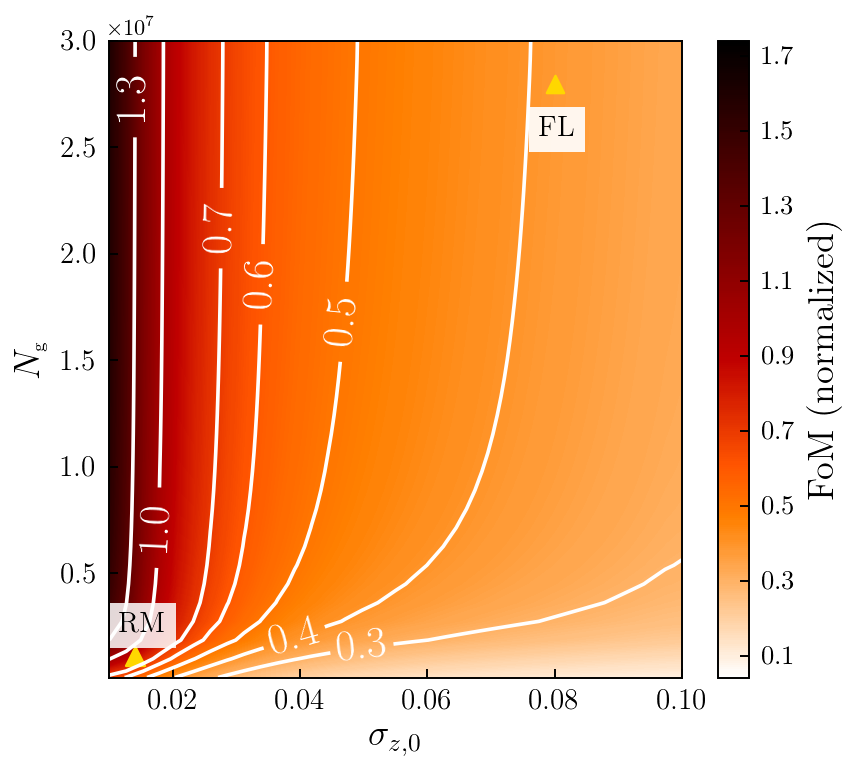

In [33]:
def FoM_prior_return(a_1,a_2):
    FoMino = FoM_prior_norm
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_pr = FoM_prior_return(a_1, a_2)

FoM_pr = scipy.ndimage.gaussian_filter(FoM_pr, 1)
levels = np.linspace(np.min(FoM_prior_norm),np.max(FoM_prior_norm),300)
image = plt.contourf(a_1, a_2, FoM_pr , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr, [0.3,0.4,0.5, 0.6,0.7,1.0,1.3] , colors=('w','w', 'w', 'w', 'w','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.2)
plt.clabel(C, inline=2, fontsize=18, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(0.08,2.8e7, color='gold', s=50.0, marker='^')

plt.text(0.0775, 2.55e7,'FL', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.92))
plt.scatter(0.014,1.1e6, color='gold', s=60.0, marker='^')
plt.text(0.0116, 2.2e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=12)

plt.xlabel("$\sigma_{z,0}$", fontsize=15);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=15)


plt.xlim(0.01,0.1);plt.ylim(1.0e5, 3.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9], fontsize=11)

plt.tight_layout()
plt.savefig('FoM_single_bin_priors.pdf')
plt.show() 




Also print the ratio $\frac{\mbox{FoM}_{RM,priors}}{\mbox{FoM}_{RM,fixed}}$

In [34]:
print(FoM_rm_prior/FoM_rm_fix)
print(FoM_fl_prior/FoM_fl_fix)

print(FoM_fl_prior/FoM_rm_prior)
print(FoM_rm_fix/FoM_rm_prior)

0.3532077714277152
0.0690185427536653
0.3879001828999019
2.8311947836194546


#### Further explorations of the dependence of the Figure of Merit (FoM) on the photo-z priors


Although interesting, the above is just a specific case of photo-z priors, roughly corresponding to the DES calibration on the photo-z parameters.

We want to explore more cases of photo-z priors, applied to different samples. In mind we have the following question:

"How well do we have to calibrate other samples to perform equally good, or better, than the redMaGiC sample?"

For the redMaGiC sample we will consider the above prior, $\sigma(z_b) = \sigma(\sigma_z,0) = 0.06 \sigma_{z,0}$.
As we have seen, this prior produces a FoM for the redMaGiC that it is almost equal to the fixed photo-z parameter case.

For the other samples we will plot the ratio:

\begin{equation}
\frac{\mbox{FoM}}{\mbox{FoM}_{RM}}
\end{equation}

$\mbox{FoM}_{RM}$ being the Figure of Merit of the redMaGiC sample, as a function of the parameter $\alpha \equiv \frac{\sigma({\sigma_{z,0}})}{\sigma_{z,0}}$. I.e., we assume that the error scales with the photo-z uncertainty. That way we take into account that samples with worse photo-zs also have photo-z parameters that are herder to constrain.

We select a flux-limited sample, of course, and also some samples (characterized, as usual by their size, $N_g$ and photo-z error, $\sigma_{z,0}$). We select some characteristic samples (most of them lie along or below the diagonal line that connects the RM and FL samples.

We select the following samples:

\begin{equation}
(N_g, \sigma_z) = [2.8 \times 10^7,0.08];[1.5 \times 10^7, 0.08];[1.5 \times 10^7, 0.06];[1.0 \times 10^7, 0.06];[5 \times 10^6, 0.04]
\end{equation}

the range in $\alpha$ is chosen to be $\alpha \in [10^{-4}, 10^{-1}]$.

In [35]:
#=============================================================
#parameters of the bin
z_i = 0.4
z_f = 0.6
z_m = 0.5*(z_i + z_f)
bias = 1.0 + z_m  #Common galaxy bias
z_bias = 0.0

# ============================================================
# Define the array in alpha
alpha_lin = np.linspace(-3.0,0.0,200)
alpha = 10.0**alpha_lin

# Define the samples - N_g and sig_z,0
# ============================================================
# ============================================================
N_fl, sig_fl = 2.8e7, 0.08
N_1, sig_1 = 1.5e7, 0.08
N_2, sig_2 = 1.5e7, 0.06
N_3, sig_3 = 1.0e7, 0.06
N_4, sig_4 = 5.0e6, 0.04
# ============================================================
# ============================================================
# Calculate the free fisher matrices in the above cases - i.e. without any priors

Fisher_fl_free = FSB(z_i,z_f,sig_fl,z_bias,bias,f_sky,N_fl)
Fisher_1_free = FSB(z_i,z_f,sig_1,z_bias,bias,f_sky,N_1)
Fisher_2_free = FSB(z_i,z_f,sig_2,z_bias,bias,f_sky,N_2)
Fisher_3_free = FSB(z_i,z_f,sig_3,z_bias,bias,f_sky,N_3)
Fisher_4_free = FSB(z_i,z_f,sig_4,z_bias,bias,f_sky,N_4)

# ==========================================================
# Calculate the priors - and their inverses - in all cases
# These will be arrays

prior_fl = alpha*sig_fl
prior_1 = alpha*sig_1
prior_2 = alpha*sig_2
prior_3 = alpha*sig_3
prior_4 = alpha*sig_4

#Inverses of the squares of the priors
inv_sq_prior_fl  = 1.0/(prior_fl**2.0)
inv_sq_prior_1 = 1.0/(prior_1**2.0)
inv_sq_prior_2 = 1.0/(prior_2**2.0)
inv_sq_prior_3 = 1.0/(prior_3**2.0)
inv_sq_prior_4 = 1.0/(prior_4**2.0)

# =========================================================
# =========================================================

# FoMs will also be arrays - initialize them

FoM_fl = np.zeros(len(alpha))
FoM_1 = np.zeros(len(alpha))
FoM_2 = np.zeros(len(alpha))
FoM_3 = np.zeros(len(alpha))
FoM_4 = np.zeros(len(alpha))


# ============================================================
# Calculate now 

for i in range(len(alpha)):
    Fisher_fl = np.copy(Fisher_fl_free)
    Fisher_1 = np.copy(Fisher_1_free)
    Fisher_2 = np.copy(Fisher_2_free)
    Fisher_3 = np.copy(Fisher_3_free)
    Fisher_4 = np.copy(Fisher_4_free)
    # ============================================
    # ============================================
    inv_prior_fl = inv_sq_prior_fl[i]
    inv_prior_1 = inv_sq_prior_1[i]
    inv_prior_2 = inv_sq_prior_2[i]
    inv_prior_3 = inv_sq_prior_3[i]
    inv_prior_4 = inv_sq_prior_4[i]
    
    # =============================================
    # =============================================
    # Add the priors
    
    Fisher_fl[3,3] = Fisher_fl[3,3] + inv_prior_fl
    Fisher_fl[4,4] = Fisher_fl[4,4] + inv_prior_fl
    
    Fisher_1[3,3] = Fisher_1[3,3] + inv_prior_1
    Fisher_1[4,4] = Fisher_1[4,4] + inv_prior_1
    
    Fisher_2[3,3] = Fisher_2[3,3] + inv_prior_2
    Fisher_2[4,4] = Fisher_2[4,4] + inv_prior_2
    
    Fisher_3[3,3] = Fisher_3[3,3] + inv_prior_3
    Fisher_3[4,4] = Fisher_3[4,4] + inv_prior_3
    
    Fisher_4[3,3] = Fisher_4[3,3] + inv_prior_4
    Fisher_4[4,4] = Fisher_4[4,4] + inv_prior_4
    # ===============================================
    # ===============================================
    # Marginalize 
    
    Fish_fl_marg = marg(Fisher_fl)
    Fish_1_marg = marg(Fisher_1)
    Fish_2_marg = marg(Fisher_2)
    Fish_3_marg = marg(Fisher_3)
    Fish_4_marg = marg(Fisher_4)
    # ======================================================
    # ======================================================
    # Calculate the FoMs
    
    FoM_fl[i] = np.sqrt(np.linalg.det(Fish_fl_marg))
    FoM_1[i] = np.sqrt(np.linalg.det(Fish_1_marg))
    FoM_2[i] = np.sqrt(np.linalg.det(Fish_2_marg))
    FoM_3[i] = np.sqrt(np.linalg.det(Fish_3_marg))
    FoM_4[i] = np.sqrt(np.linalg.det(Fish_4_marg))

# ===========================================================================
# ===========================================================================

# Normalize to the FoM of the redMaGiC sample

FoM_fl = FoM_fl/FoM_rm_prior
FoM_1 = FoM_1/FoM_rm_prior
FoM_2 = FoM_2/FoM_rm_prior
FoM_3 = FoM_3/FoM_rm_prior
FoM_4 = FoM_4/FoM_rm_prior

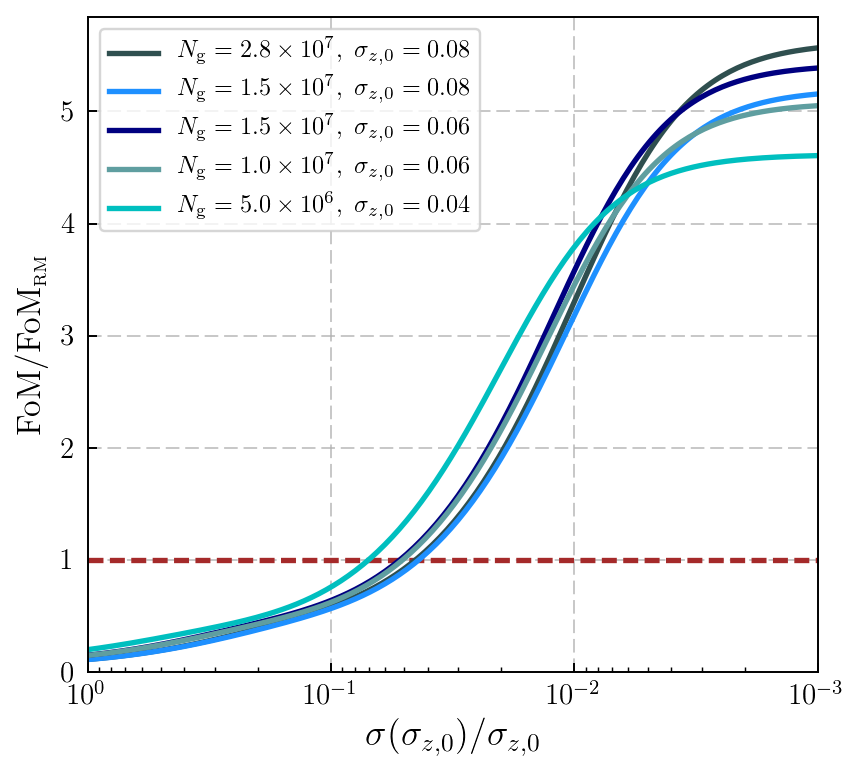

In [36]:
fig = plt.figure(figsize = (5.0,4.5))

plt.plot(alpha, FoM_fl, c='darkslategrey', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=2.8 \times 10^7, \,\, \sigma_{z,0} = 0.08$')
plt.plot(alpha, FoM_1, c='dodgerblue',  linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=1.5 \times 10^7, \,\, \sigma_{z,0} = 0.08$')
plt.plot(alpha, FoM_2, c='navy', linewidth=2.2,label=r'$N_{\mbox{\scriptsize{g}}}=1.5 \times 10^7, \,\, \sigma_{z,0} = 0.06$')
plt.plot(alpha, FoM_3, c='cadetblue', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}= 1.0 \times 10^7, \,\, \sigma_{z,0} = 0.06$')
plt.plot(alpha, FoM_4, c='c', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=5.0 \times 10^6, \,\, \sigma_{z,0} = 0.04$')

plt.hlines(1.0,1,1e-3, color='brown', linestyle='--', linewidth= 2.2)

plt.ylabel('FoM/FoM$_{\scriptsize{\mbox{RM}}}$',fontsize=14)
plt.xlabel('$\sigma(\sigma_{z,0})/\sigma_{z,0}$',fontsize=15)
plt.tick_params(axis='both', labelsize=12)

plt.grid(ls='--', alpha=0.7)

plt.xscale('log');plt.xlim(1.0,1e-3);plt.ylim(0.0,)
plt.legend(frameon=True, loc='upper left', fontsize=10)


plt.tight_layout()
plt.savefig('FoMs_size.pdf')
plt.show()

Placeholder: Explain the above plot

Now, we want to make a plot similar to the above, but now as a a function of the spectroscopic calibration sample.

Here I will use the expressions:

\begin{equation}
\Delta z_{bias} = \frac{\sigma_z}{\sqrt{N_{spec}}}
\end{equation}

and 

\begin{equation}
\Delta \sigma_z = \frac{\sigma_z}{\sqrt{N_{spec}/2}}
\end{equation}

I will plot the ratio:

\begin{equation}
\frac{\mbox{FoM}}{\mbox{FoM}_{fix}},
\end{equation}

where $\mbox{FoM}_{fix}$ is the FoM with fixed photo-z parameters. I will consider all the above samples plus a redMaGic-like sample.

I consider a range in spectroscopic sample $N_{spec} \in [10^3, 10^6]$

In [37]:
# Free redMaGic Fisher matrix
N_rm, sig_rm = 1.1e6, 0.014
Fisher_rm_free = FSB(z_i,z_f,sig_rm,z_bias,bias,f_sky,N_rm)
# =================================================================
# =================================================================
# Define an array of spectroscopic calibration sample sizes 
N_spec_lin = np.linspace(3.0,6.0,200)
N_spec = 10.0**N_spec_lin

# ====================================================================
# ====================================================================
# Define arrays with the priors - now different for the scatter and the bias
prior_rm_zb = sig_rm*(1.0+z_m)/sqrt(N_spec)
prior_rm_scat = sig_rm/sqrt(N_spec/2.0)

prior_fl_zb = sig_fl*(1.0+z_m)/sqrt(N_spec)
prior_fl_scat = sig_fl/sqrt(N_spec/2.0)

prior_1_zb = sig_1*(1.0+z_m)/sqrt(N_spec)
prior_1_scat = sig_1/sqrt(N_spec/2.0)

prior_2_zb = sig_2*(1.0+z_m)/sqrt(N_spec)
prior_2_scat = sig_2/sqrt(N_spec/2.0)

prior_3_zb = sig_3*(1.0+z_m)/sqrt(N_spec)
prior_3_scat = sig_3/sqrt(N_spec/2.0)

prior_4_zb = sig_4*(1.0+z_m)/sqrt(N_spec)
prior_4_scat = sig_4/sqrt(N_spec/2.0)

# ======================================================================
# ======================================================================
# Inverses of the squares of the priors -that is what we are going to need later
inv_sq_prior_rm_zb = 1.0/(prior_rm_zb**2.0)
inv_sq_prior_rm_scat = 1.0/(prior_rm_scat**2.0)

inv_sq_prior_fl_zb = 1.0/(prior_fl_zb**2.0)
inv_sq_prior_fl_scat = 1.0/(prior_fl_scat**2.0)

inv_sq_prior_1_zb = 1.0/(prior_1_zb**2.0)
inv_sq_prior_1_scat = 1.0/(prior_1_scat**2.0)

inv_sq_prior_2_zb = 1.0/(prior_2_zb**2.0)
inv_sq_prior_2_scat = 1.0/(prior_2_scat**2.0)

inv_sq_prior_3_zb = 1.0/(prior_3_zb**2.0)
inv_sq_prior_3_scat = 1.0/(prior_3_scat**2.0)

inv_sq_prior_4_zb = 1.0/(prior_4_zb**2.0)
inv_sq_prior_4_scat = 1.0/(prior_4_scat**2.0)
                           
                                                     
inv_sq_prior_bias = 0.0#1.0/(0.005**2.0)
# =========================================================
# =========================================================

# FoMs will also be arrays - initialize them

FoM_rm = np.zeros(len(N_spec))
FoM_fl = np.zeros(len(N_spec))
FoM_1 = np.zeros(len(N_spec))
FoM_2 = np.zeros(len(N_spec))
FoM_3 = np.zeros(len(N_spec))
FoM_4 = np.zeros(len(N_spec))

# ============================================================
# Calculate now 

for i in range(len(N_spec)):
    Fisher_rm = np.copy(Fisher_rm_free)
    Fisher_fl = np.copy(Fisher_fl_free)
    Fisher_1 = np.copy(Fisher_1_free)
    Fisher_2 = np.copy(Fisher_2_free)
    Fisher_3 = np.copy(Fisher_3_free)
    Fisher_4 = np.copy(Fisher_4_free)
    
    # =======================================================
    # =======================================================
    inv_prior_rm_zb = inv_sq_prior_rm_zb[i]
    inv_prior_rm_scat = inv_sq_prior_rm_scat[i]
    
    inv_prior_fl_zb = inv_sq_prior_fl_zb[i]
    inv_prior_fl_scat = inv_sq_prior_fl_scat[i]
    
    inv_prior_1_zb = inv_sq_prior_1_zb[i]
    inv_prior_1_scat = inv_sq_prior_1_scat[i]
    
    inv_prior_2_zb = inv_sq_prior_2_zb[i]
    inv_prior_2_scat = inv_sq_prior_2_scat[i]
    
    inv_prior_3_zb = inv_sq_prior_3_zb[i]
    inv_prior_3_scat = inv_sq_prior_3_scat[i]
    
    inv_prior_4_zb = inv_sq_prior_4_zb[i]
    inv_prior_4_scat = inv_sq_prior_4_scat[i]
    # ======================================================
    # ======================================================
    # Add the priors now 
    
    Fisher_rm[2,2] = Fisher_rm[2,2] + inv_sq_prior_bias
    Fisher_rm[3,3] = Fisher_rm[3,3] + inv_prior_rm_zb
    Fisher_rm[4,4] = Fisher_rm[4,4] + inv_prior_rm_scat
    
    Fisher_fl[2,2] = Fisher_fl[2,2] + inv_sq_prior_bias
    Fisher_fl[3,3] = Fisher_fl[3,3] + inv_prior_fl_zb
    Fisher_fl[4,4] = Fisher_fl[4,4] + inv_prior_fl_scat
    
    Fisher_1[2,2] = Fisher_1[2,2] + inv_sq_prior_bias                       
    Fisher_1[3,3] = Fisher_1[3,3] + inv_prior_2_zb
    Fisher_1[4,4] = Fisher_1[4,4] + inv_prior_2_scat
    
    Fisher_2[2,2] = Fisher_2[2,2] + inv_sq_prior_bias                       
    Fisher_2[3,3] = Fisher_2[3,3] + inv_prior_2_zb
    Fisher_2[4,4] = Fisher_2[4,4] + inv_prior_2_scat
    
    Fisher_3[2,2] = Fisher_3[2,2] + inv_sq_prior_bias
    Fisher_3[3,3] = Fisher_3[3,3] + inv_prior_3_zb
    Fisher_3[4,4] = Fisher_3[4,4] + inv_prior_3_scat
    
    Fisher_4[2,2] = Fisher_4[2,2] + inv_sq_prior_bias                       
    Fisher_4[3,3] = Fisher_4[3,3] + inv_prior_4_zb
    Fisher_4[4,4] = Fisher_4[4,4] + inv_prior_4_scat
    # ======================================================
    # ======================================================
    # Marginalize now
    
    Fish_rm_marg = marg(Fisher_rm)
    Fish_fl_marg = marg(Fisher_fl)
    Fish_1_marg = marg(Fisher_1)
    Fish_2_marg = marg(Fisher_2)
    Fish_3_marg = marg(Fisher_3)
    Fish_4_marg = marg(Fisher_4)
     
    # ====================================================================
    # ====================================================================
    # Calculate the Figures of Merit now (FoMs)
    
    FoM_rm[i] = np.sqrt(np.linalg.det(Fish_rm_marg))
    FoM_fl[i] = np.sqrt(np.linalg.det(Fish_fl_marg))
    FoM_1[i] = np.sqrt(np.linalg.det(Fish_1_marg))
    FoM_2[i] = np.sqrt(np.linalg.det(Fish_2_marg))
    FoM_3[i] = np.sqrt(np.linalg.det(Fish_3_marg))
    FoM_4[i] = np.sqrt(np.linalg.det(Fish_4_marg))
    


# =========================================================================
# =========================================================================
# =========================================================================
# Calculate Fixed case now to normalize 

inv_prior_fix = 1.0e30

Fisher_rm_fix = np.copy(Fisher_rm_free)
Fisher_fl_fix = np.copy(Fisher_fl_free)
Fisher_1_fix = np.copy(Fisher_1_free)
Fisher_2_fix = np.copy(Fisher_2_free)
Fisher_3_fix = np.copy(Fisher_3_free)
Fisher_4_fix = np.copy(Fisher_4_free)

# =========================================================================
# =========================================================================                 
Fisher_rm_fix[3,3] = Fisher_rm_fix[3,3] + inv_prior_fix
Fisher_rm_fix[4,4] = Fisher_rm_fix[4,4] + inv_prior_fix

                        
Fisher_fl_fix[3,3] = Fisher_fl_fix[3,3] + inv_prior_fix
Fisher_fl_fix[4,4] = Fisher_fl_fix[4,4] + inv_prior_fix
                      
Fisher_1_fix[3,3] = Fisher_1_fix[3,3] + inv_prior_fix
Fisher_1_fix[4,4] = Fisher_1_fix[4,4] + inv_prior_fix
                           

Fisher_2_fix[3,3] = Fisher_2_fix[3,3] + inv_prior_fix
Fisher_2_fix[4,4] = Fisher_2_fix[4,4] + inv_prior_fix

                        
Fisher_3_fix[3,3] = Fisher_3_fix[3,3] + inv_prior_fix
Fisher_3_fix[4,4] = Fisher_3_fix[4,4] + inv_prior_fix

                          
Fisher_4_fix[3,3] = Fisher_4_fix[3,3] + inv_prior_fix
Fisher_4_fix[4,4] = Fisher_4_fix[4,4] + inv_prior_fix

# Marginalize now

Fish_fix_rm_marg = marg(Fisher_rm_fix)
Fish_fix_fl_marg = marg(Fisher_fl_fix)
Fish_fix_1_marg = marg(Fisher_1_fix)
Fish_fix_2_marg = marg(Fisher_2_fix)
Fish_fix_3_marg = marg(Fisher_3_fix)
Fish_fix_4_marg = marg(Fisher_4_fix)

# Calculation of the FoMs for the fixed case

FoM_rm_fix = np.sqrt(np.linalg.det(Fish_fix_rm_marg))
FoM_fl_fix = np.sqrt(np.linalg.det(Fish_fix_fl_marg))
FoM_1_fix = np.sqrt(np.linalg.det(Fish_fix_1_marg))
FoM_2_fix = np.sqrt(np.linalg.det(Fish_fix_2_marg))
FoM_3_fix = np.sqrt(np.linalg.det(Fish_fix_3_marg))
FoM_4_fix = np.sqrt(np.linalg.det(Fish_fix_4_marg))

# ======================================================================
# ======================================================================

FoM_rm_nor = FoM_rm/FoM_rm_fix
FoM_fl_nor = FoM_fl/FoM_fl_fix
FoM_1_nor = FoM_1/FoM_1_fix
FoM_2_nor = FoM_2/FoM_2_fix
FoM_3_nor = FoM_3/FoM_3_fix
FoM_4_nor = FoM_4/FoM_4_fix

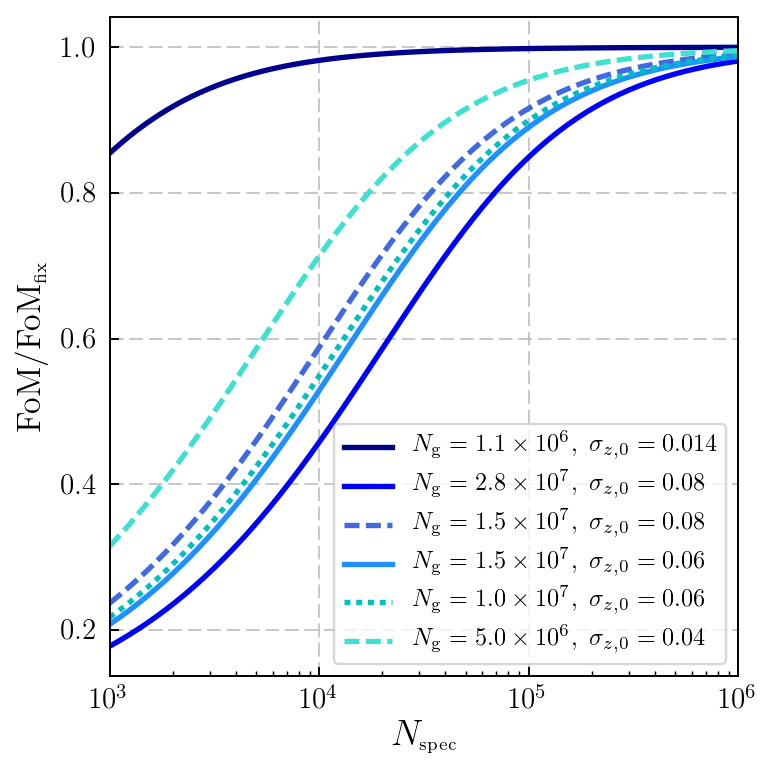

In [38]:
fig = plt.figure(figsize = (4.5,4.5))

plt.plot(N_spec, FoM_rm_nor, c='darkblue', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=1.1 \times 10^6, \,\, \sigma_{z,0} = 0.014$' )
plt.plot(N_spec, FoM_fl_nor, c='blue', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=2.8 \times 10^7, \,\, \sigma_{z,0} = 0.08$')
plt.plot(N_spec, FoM_1_nor, c='royalblue',  linewidth=2.2, ls='--', label=r'$N_{\mbox{\scriptsize{g}}}=1.5 \times 10^7, \,\, \sigma_{z,0} = 0.08$')
plt.plot(N_spec, FoM_2_nor, c='dodgerblue', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=1.5 \times 10^7, \,\, \sigma_{z,0} = 0.06$')
plt.plot(N_spec, FoM_3_nor, c='c', linewidth=2.2, ls=':', label=r'$N_{\mbox{\scriptsize{g}}}= 1.0 \times 10^7, \,\, \sigma_{z,0} = 0.06$')
plt.plot(N_spec, FoM_4_nor, c='turquoise', linewidth=2.2, ls='--', label=r'$N_{\mbox{\scriptsize{g}}}=5.0 \times 10^6, \,\, \sigma_{z,0} = 0.04$')

plt.hlines(1.0,1,1e-3, color='brown', linestyle='--', linewidth= 2.2)

plt.ylabel('FoM/FoM$_{\scriptsize{\mbox{fix}}}$',fontsize=14)
plt.xlabel('$N_{\mbox{\scriptsize{spec}}}$',fontsize=15)
plt.tick_params(axis='both', labelsize=12)

plt.grid(ls='--', alpha=0.7)

plt.xscale('log');plt.xlim(1e3,1e6)
plt.legend(frameon=True, loc='lower right', fontsize=10)


plt.tight_layout()
plt.savefig('FoMs_spec.pdf')
plt.show()

One more interesting plot I am going to present here is the following:

\begin{equation}
\frac{\mbox{FoM}}{\mbox{FoM}_{RM,fix}}
\end{equation}

So, here I normalize everything to the Figure of Merit of the redMaGiC-like sample with fixed photo-z's

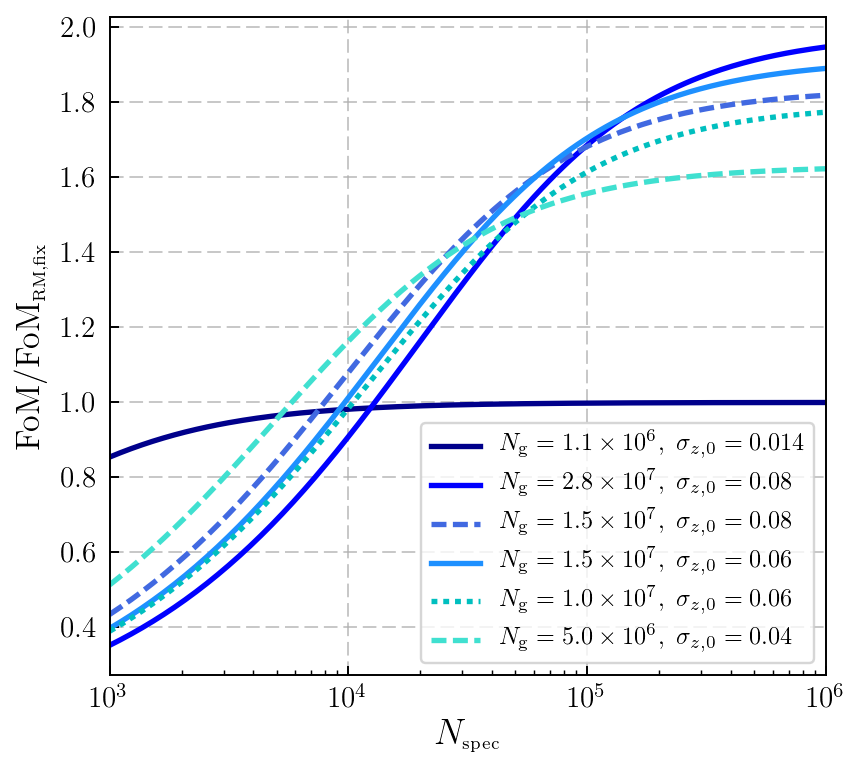

In [39]:
FoM_rm_tofix = FoM_rm/FoM_rm_fix
FoM_fl_tofix = FoM_fl/FoM_rm_fix
FoM_1_tofix = FoM_1/FoM_rm_fix
FoM_2_tofix = FoM_2/FoM_rm_fix
FoM_3_tofix = FoM_3/FoM_rm_fix
FoM_4_tofix = FoM_4/FoM_rm_fix
#==================================================================
#==================================================================
# Plot them now 
#==================================================================
fig = plt.figure(figsize = (5.0,4.5))

plt.plot(N_spec, FoM_rm_tofix, c='darkblue', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=1.1 \times 10^6, \,\, \sigma_{z,0} = 0.014$' )
plt.plot(N_spec, FoM_fl_tofix, c='blue', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=2.8 \times 10^7, \,\, \sigma_{z,0} = 0.08$')
plt.plot(N_spec, FoM_1_tofix, c='royalblue',  linewidth=2.2, ls='--', label=r'$N_{\mbox{\scriptsize{g}}}=1.5 \times 10^7, \,\, \sigma_{z,0} = 0.08$')
plt.plot(N_spec, FoM_2_tofix, c='dodgerblue', linewidth=2.2, label=r'$N_{\mbox{\scriptsize{g}}}=1.5 \times 10^7, \,\, \sigma_{z,0} = 0.06$')
plt.plot(N_spec, FoM_3_tofix, c='c', linewidth=2.2, ls=':', label=r'$N_{\mbox{\scriptsize{g}}}= 1.0 \times 10^7, \,\, \sigma_{z,0} = 0.06$')
plt.plot(N_spec, FoM_4_tofix, c='turquoise', linewidth=2.2, ls='--', label=r'$N_{\mbox{\scriptsize{g}}}=5.0 \times 10^6, \,\, \sigma_{z,0} = 0.04$')

plt.hlines(1.0,1,1e-3, color='brown', linestyle='--', linewidth= 2.2)

plt.ylabel('FoM/FoM$_{\scriptsize{\mbox{RM,fix}}}$',fontsize=14)
plt.xlabel('$N_{\mbox{\scriptsize{spec}}}$',fontsize=15)
plt.tick_params(axis='both', labelsize=12)

plt.grid(ls='--', alpha=0.7)

plt.xscale('log');plt.xlim(1e3,1e6)
plt.legend(frameon=True, loc='lower right', fontsize=10)


plt.tight_layout()
plt.savefig('FoMs.pdf')
plt.show()

### Figure-of-Merit contour plot in a smaller region

From the above plot it seems that for realistic priors on the photo-z parameters (calibration/validation of the photo-zs) big samples (full flux limited sample with $i < 22$) with large photo-z's cannot give constraints competitive to the constraints from a photo-z sample. 

So, samples with photo-z errors $\sim 7-8$ higher and sizes $10-20$ times larer than those of the redMaGiC sample are unlikely to give better constraints, for realistic validation abilities / calibration sizes.

Let's focus in a smaller region around the redMaGiC sample, say:

\begin{equation}
0.01 \leq \sigma_{z,0} \leq 0.04
\end{equation} 

and:

\begin{equation}
10^5 \leq N_g \leq 10^6
\end{equation}

(I may change the above)

I will adopt a constant (among different samples) photo-z prior:

\begin{equation}
\sigma({z_b}) \sim \sigma(\sigma_{z,0}) \sim 0.0075
\end{equation}

(prediction for DES Y3  - DES Michigan meeting)

Later, for specific samples I will explore the dependence on the redshift prior, as above, but for samples closer to the redMaGiC one.

In [40]:
# Array of sample sizes and redshift errors
#N_gal_arr = np.linspace(1.0e5, 1.0e7, 30)
#sig_z_arr = np.linspace(0.01, 0.04, 30)
#size = np.size(N_gal_arr)

In [43]:
# Prior - define it here since I assume it to be constant
# ======================================================================================
prior = 0.0075
inv_sq_prior = 1.0/(prior**2.0)
#

# ======================================================================================
# ======================================================================================
# Initialize matrix
#FoM_prior_small = np.zeros([size,size])

#for i in range(size):
#    sig_z = sig_z_arr[i]
#    for j in range(size):
#        N_gal = N_gal_arr[j]
        
        #Calculate the Fisher matrix now -without any prior
#        Fish_mat = FSB(z_i,z_f,sig_z,z_bias,bias,f_sky,N_gal)

        
#        Fish_mat[3,3] = Fish_mat[3,3] + inv_sq_prior
#        Fish_mat[4,4] = Fish_mat[4,4] + inv_sq_prior
        
        #Marginalize over the nuisance parameters now
#        Fish_marg = marg(Fish_mat)
        
#        FoM_prior_small[i][j] = np.sqrt(np.linalg.det(Fish_marg))

In [44]:
# Calculate the FoM for the redMaGiC sample with the above common prior

# Free Fisher matrix - no redshift errors for redMaGiC
Fish_rm_Free = FSB(z_i,z_f, sig_rm, z_bias, bias, f_sky, N_rm)

# Add the priors now
# =======================================================================

Fish_rm_prior_small = np.copy(Fish_rm_Free) 
Fish_rm_prior_small[3,3] = Fish_rm_prior_small[3,3] + inv_sq_prior
Fish_rm_prior_small[4,4] = Fish_rm_prior_small[4,4] + inv_sq_prior
# =======================================================================
# Marginalize over the nuisance parameters
Fish_rm_prior_small_marg = marg(Fish_rm_prior_small)

# Calculate now the Figure of Merit 
#FoM_rm_prior_small = np.sqrt(np.linalg.det(Fish_rm_prior_small_marg))

In [45]:
# Normalize the matrix now - for the constant prior
# =================================================
#FoM_prior_small_tr = np.matrix.transpose(FoM_prior_small)
#FoM_prior_small_norm = FoM_prior_small_tr/(FoM_rm_prior_small)

Plot now

In [46]:
#def FoM_prior_return(a_1,a_2):
#    FoMino = FoM_prior_small_norm
#    return FoMino
# =============================================================================
# =============================================================================
#fig = plt.figure(figsize = (5.0,4.5))

#a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
#FoM_pr = FoM_prior_return(a_1, a_2)

#FoM_pr = scipy.ndimage.gaussian_filter(FoM_pr, 1)
#levels = np.linspace(np.min(FoM_prior_small_norm),np.max(FoM_prior_small_norm),300)
#image = plt.contourf(a_1, a_2, FoM_pr , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

#C = plt.contour(a_1,a_2, FoM_pr, [0.6, 0.9,1.0,1.1, 1.2,1.3,1.4, 1.5, 1.6,1.8,2.2] , colors=('w','w', 'w', 'w', 'w','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.0)
#plt.clabel(C, inline=2, fontsize=18, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


#plt.scatter(0.08,2.8e7, color='gold', s=50.0, marker='^')

#plt.text(0.0775, 2.55e7,'FL', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
#plt.scatter(0.014,1.1e6, color='gold', s=60.0, marker='^')
#plt.text(0.013, 1.7e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
#plt.tick_params(axis='both', labelsize=12)

#plt.xlabel("$\sigma_{z,0}$", fontsize=15);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=15)


#plt.xlim(0.01,0.04);plt.ylim(1.0e5, 1.0e7)

#cbar = plt.colorbar(image, orientation='vertical', ticks=[0.4,0.6, 0.8,1.0, 1.2,1.4,1.6,1.7,1.8, 1.85,2.0,2.1,2.2])
#cbar.set_label('FoM (normalized)', fontsize=15)
#cbar.ax.set_yticklabels([0.4,0.6, 0.8,1.0, 1.2,1.4,1.6,1.8, 1.85,2.0,2.1,2.2], fontsize=11)

#plt.tight_layout()
#plt.savefig('FoM_single_bin_priors.pdf')
#plt.show() 





Now, pick some samples and compare them to the redMaGiC sample as a function of prior.

I pick the following:

\begin{equation}
N_g = 1.1 \times 10^6, \quad \sigma_{z,0} = 0.014 \qquad (redMaGic)\\
N_g = 2.0 \times 10^6, \quad \sigma_{z,0} = 0.020 \\
N_g = 4.0 \times 10^6, \quad \sigma_{z,0} = 0.020 \\
N_g = 2.0 \times 10^6, \quad \sigma_{z,0} = 0.025 \\
N_g = 4.0 \times 10^6, \quad \sigma_{z,0} = 0.025 \\
N_g = 4.0 \times 10^6, \quad \sigma_{z,0} = 0.030 \\
N_g = 6.0 \times 10^6, \quad \sigma_{z,0} = 0.030 \\
\end{equation}

For the prior range I addopt:

\begin{equation}
\frac{\sigma(\sigma_{z,0})}{\sigma_{z,0}} \in [10^{-3},10^0]
\end{equation}

Furthermore, I assume that:

\begin{equation}
\sigma(z_b) = \sigma(\sigma_{z,0})
\end{equation}

For these samples I will plot the ratio:

\begin{equation}
\frac{\mbox{FoM}}{\mbox{FoM}_{RM, fix}},
\end{equation}

where $\mbox{FoM}_{RM, fix}$ the figure of merit of the redMaGiC samples  as a function of the prior.



In [47]:
#==================================================================
#==================================================================
#parameters of the bin - just to be sure
z_i = 0.4
z_f = 0.6
z_m = 0.5*(z_i + z_f)
bias = 1.0 + z_m  #Common galaxy bias
z_bias = 0.0
#=================================================================
#=================================================================

#==================================================================
# Define the array in alpha
alpha_lin = np.linspace(-3.0,0.0,200)
alpha = 10.0**alpha_lin

#==================================================================
#==================================================================
# Define the samples - N_g and sig_z,0

N_rm, sig_rm = 1.1e6, 0.014
N_1, sig_1 = 2.0e6, 0.02
N_2, sig_2 = 4.0e6, 0.02
N_3, sig_3 = 2.0e6, 0.025
N_4, sig_4 = 4.0e6, 0.025
N_5, sig_5 = 4.0e6, 0.03
N_6, sig_6 = 6.0e6, 0.03

# ============================================================
# ============================================================
# Calculate the free fisher matrices in the above cases - i.e. without any priors

Fisher_rm_free = FSB(z_i,z_f,sig_rm,z_bias,bias,f_sky,N_rm)
Fisher_1_free = FSB(z_i,z_f,sig_1,z_bias,bias,f_sky,N_1)
Fisher_2_free = FSB(z_i,z_f,sig_2,z_bias,bias,f_sky,N_2)
Fisher_3_free = FSB(z_i,z_f,sig_3,z_bias,bias,f_sky,N_3)
Fisher_4_free = FSB(z_i,z_f,sig_4,z_bias,bias,f_sky,N_4)
Fisher_5_free = FSB(z_i,z_f,sig_5,z_bias,bias,f_sky,N_5)
Fisher_6_free = FSB(z_i,z_f,sig_6,z_bias,bias,f_sky,N_6)

# =============================================================
# =============================================================
# Calculate the priors - and their inverses - in all cases
# These will be arrays

prior_rm = alpha*sig_rm
prior_1 = alpha*sig_1
prior_2 = alpha*sig_2
prior_3 = alpha*sig_3
prior_4 = alpha*sig_4
prior_5 = alpha*sig_5
prior_6 = alpha*sig_6


#Inverses of the squares of the priors
inv_sq_prior_rm  = 1.0/(prior_rm**2.0)
inv_sq_prior_1 = 1.0/(prior_1**2.0)
inv_sq_prior_2 = 1.0/(prior_2**2.0)
inv_sq_prior_3 = 1.0/(prior_3**2.0)
inv_sq_prior_4 = 1.0/(prior_4**2.0)
inv_sq_prior_5 = 1.0/(prior_5**2.0)
inv_sq_prior_6 = 1.0/(prior_6**2.0)

# ==============================================================
# ==============================================================

# =========================================================
# =========================================================
# FoMs will also be arrays - initialize them

FoM_rm = np.zeros(len(alpha))
FoM_1 = np.zeros(len(alpha))
FoM_2 = np.zeros(len(alpha))
FoM_3 = np.zeros(len(alpha))
FoM_4 = np.zeros(len(alpha))
FoM_5 = np.zeros(len(alpha))
FoM_6 = np.zeros(len(alpha))
# ============================================================
# Calculate now 

for i in range(len(alpha)):
    Fisher_rm = np.copy(Fisher_rm_free)
    Fisher_1 = np.copy(Fisher_1_free)
    Fisher_2 = np.copy(Fisher_2_free)
    Fisher_3 = np.copy(Fisher_3_free)
    Fisher_4 = np.copy(Fisher_4_free)
    Fisher_5 = np.copy(Fisher_5_free)
    Fisher_6 = np.copy(Fisher_6_free)
    # ============================================
    # ============================================
    inv_prior_rm = inv_sq_prior_rm[i]
    inv_prior_1 = inv_sq_prior_1[i]
    inv_prior_2 = inv_sq_prior_2[i]
    inv_prior_3 = inv_sq_prior_3[i]
    inv_prior_4 = inv_sq_prior_4[i]
    inv_prior_5 = inv_sq_prior_5[i]
    inv_prior_6 = inv_sq_prior_6[i]
    
    # =============================================
    # =============================================
    # Add the priors
    
    Fisher_rm[3,3] = Fisher_rm[3,3] + inv_prior_rm
    Fisher_rm[4,4] = Fisher_rm[4,4] + inv_prior_rm
    
    Fisher_1[3,3] = Fisher_1[3,3] + inv_prior_1
    Fisher_1[4,4] = Fisher_1[4,4] + inv_prior_1
    
    Fisher_2[3,3] = Fisher_2[3,3] + inv_prior_2
    Fisher_2[4,4] = Fisher_2[4,4] + inv_prior_2
    
    Fisher_3[3,3] = Fisher_3[3,3] + inv_prior_3
    Fisher_3[4,4] = Fisher_3[4,4] + inv_prior_3
    
    Fisher_4[3,3] = Fisher_4[3,3] + inv_prior_4
    Fisher_4[4,4] = Fisher_4[4,4] + inv_prior_4
    
    Fisher_5[3,3] = Fisher_5[3,3] + inv_prior_5
    Fisher_5[4,4] = Fisher_5[4,4] + inv_prior_5
    
    Fisher_6[3,3] = Fisher_6[3,3] + inv_prior_6
    Fisher_6[4,4] = Fisher_6[4,4] + inv_prior_6
    # ===============================================
    # ===============================================
    # Marginalize 
    
    Fish_rm_marg = marg(Fisher_rm)
    Fish_1_marg = marg(Fisher_1)
    Fish_2_marg = marg(Fisher_2)
    Fish_3_marg = marg(Fisher_3)
    Fish_4_marg = marg(Fisher_4)
    Fish_5_marg = marg(Fisher_5)
    Fish_6_marg = marg(Fisher_6)
    # ======================================================
    # ======================================================
    # Calculate the FoMs
    
    FoM_rm[i] = np.sqrt(np.linalg.det(Fish_rm_marg))
    FoM_1[i] = np.sqrt(np.linalg.det(Fish_1_marg))
    FoM_2[i] = np.sqrt(np.linalg.det(Fish_2_marg))
    FoM_3[i] = np.sqrt(np.linalg.det(Fish_3_marg))
    FoM_4[i] = np.sqrt(np.linalg.det(Fish_4_marg))
    FoM_5[i] = np.sqrt(np.linalg.det(Fish_5_marg))
    FoM_6[i] = np.sqrt(np.linalg.det(Fish_6_marg))

# ===========================================================================
# ===========================================================================
# FoM of redMaGiC sample with Fixed photo-z's 
inv_fix_prior = 1.0e30

Fisher_rm_fix = np.copy(Fisher_rm_free)
Fisher_rm_fix[3,3] = Fisher_rm_fix[3,3] + inv_fix_prior
Fisher_rm_fix[4,4] = Fisher_rm_fix[4,4] + inv_fix_prior

Fisher_rm_fix_marg = marg(Fisher_rm_fix)
FoM_rm_fix  = np.sqrt(np.linalg.det(Fish_rm_fix_marg))

# ===========================================================================
# ===========================================================================
# Normalize to the FoM of the fixed photo-zs 

FoM_rm = FoM_rm/FoM_rm_fix 
FoM_1 = FoM_1/FoM_rm_fix
FoM_2 = FoM_2/FoM_rm_fix
FoM_3 = FoM_3/FoM_rm_fix
FoM_4 = FoM_4/FoM_rm_fix
FoM_5 = FoM_5/FoM_rm_fix
FoM_6 = FoM_6/FoM_rm_fix

#### Plot them

Make the plot now

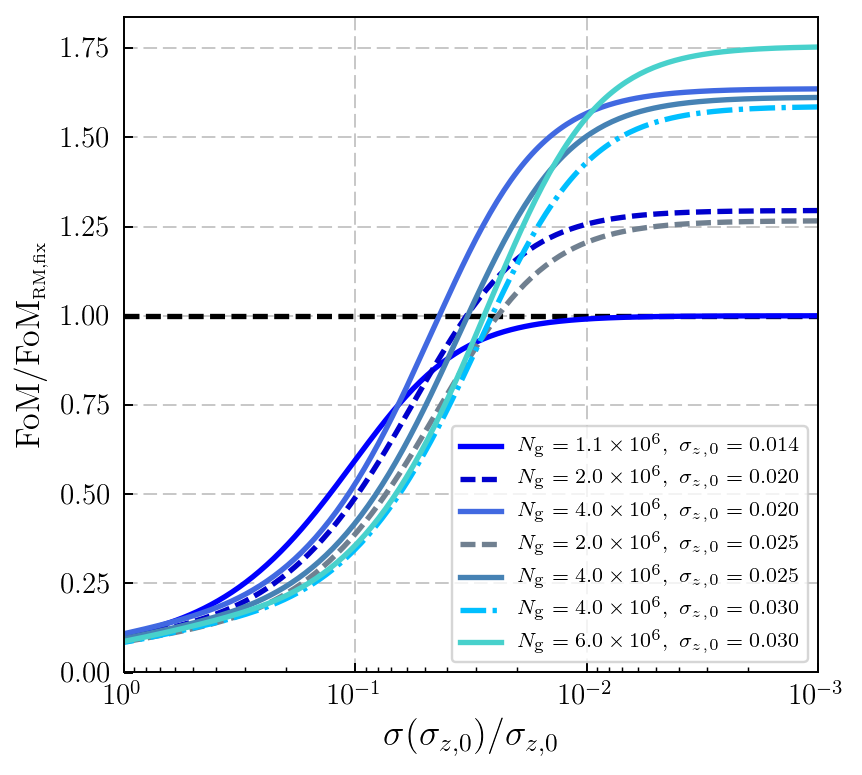

In [48]:
fig = plt.figure(figsize = (5.0,4.5))


plt.plot(alpha, FoM_rm, linewidth=2.2, c='b', label=r'$N_{\mbox{\scriptsize{g}}}=1.1 \times 10^6, \,\, \sigma_{z,0} = 0.014$')
plt.plot(alpha, FoM_1, linewidth=2.2, c='mediumblue', ls='--', label=r'$N_{\mbox{\scriptsize{g}}}=2.0 \times 10^6, \,\, \sigma_{z,0} = 0.020$')
plt.plot(alpha, FoM_2, linewidth=2.2, c='royalblue', label=r'$N_{\mbox{\scriptsize{g}}}=4.0 \times 10^6, \,\, \sigma_{z,0} = 0.020$')
plt.plot(alpha, FoM_3, linewidth=2.2, c='slategray', ls='--', label=r'$N_{\mbox{\scriptsize{g}}}=2.0 \times 10^6, \,\, \sigma_{z,0} = 0.025$')
plt.plot(alpha, FoM_4, linewidth=2.2, c='steelblue', label=r'$N_{\mbox{\scriptsize{g}}}=4.0 \times 10^6, \,\, \sigma_{z,0} = 0.025$')
plt.plot(alpha, FoM_5, linewidth=2.2, c='deepskyblue',ls='-.' ,label=r'$N_{\mbox{\scriptsize{g}}}=4.0 \times 10^6, \,\, \sigma_{z,0} = 0.030$')
plt.plot(alpha, FoM_6, linewidth=2.2, c='mediumturquoise', label=r'$N_{\mbox{\scriptsize{g}}}=6.0 \times 10^6, \,\, \sigma_{z,0} = 0.030$')

plt.hlines(1.0,1,1e-3, color='k', linestyle='--', linewidth= 2.2)

plt.ylabel('FoM/FoM$_{\scriptsize{\mbox{RM,fix}}}$',fontsize=14)
plt.xlabel('$\sigma(\sigma_{z,0})/\sigma_{z,0}$',fontsize=15)
plt.tick_params(axis='both', labelsize=12)


plt.grid(ls='--', alpha=0.7)

plt.legend(frameon=True, loc='lower right', fontsize=8.5)


plt.xscale('log');plt.xlim(1.0,1e-3)

plt.tight_layout()

plt.savefig('FoM_priors_1.pdf')
plt.show()

### Some forecasted constraints - confidence ellipses plots 

In all above cases we have used the Figure of Merit (for the set of parameters $\Omega_m$ and $\sigma_8$) to compare different samples. It is convenient to use the FoM, because we can use a single number that captures the constraining power on both cosmological parameters. 

However it may not be intuitive what an increase of the figure of merit by $\sim 2$ or $\sim 1.3$ actually means. So, it will be good to plot here some of the confidence ellipses. 

##### Flux limited and redMaGiC samples with fixed photo-z parameters

We have found a ratio of the Figures of Merit of the order of $\sim 1.985$ in that case. Let's plot the contours in that case.

In [49]:
# ============================================================================
# Definition of the two samples
sig_rm = 0.014 #Redshift error of the redMaGiC-like sample
sig_fl = 0.08 #Redshift error of the Flux limited-like sample
N_rm = 1.1e6 # Size of the redMaGiC-like sample
N_fl = 2.8e7 # Size of the flux-limited like sample
# ============================================================================
# ============================================================================
# Free Fisher matrices
Fisher_rm_free = FSB(z_i,z_f,sig_rm,z_bias,bias,f_sky,N_rm)
Fisher_fl_free = FSB(z_i,z_f,sig_fl,z_bias,bias,f_sky,N_fl)


Fisher_rm_fix = np.copy(Fisher_rm_free)
Fisher_fl_fix = np.copy(Fisher_fl_free)

inv_sq_prior = 1.0e35

Fisher_rm_fix[3,3] = Fisher_rm_fix[3,3] + inv_sq_prior
Fisher_rm_fix[4,4] = Fisher_rm_fix[4,4] + inv_sq_prior

Fisher_fl_fix[3,3] = Fisher_fl_fix[3,3] + inv_sq_prior
Fisher_fl_fix[4,4] = Fisher_fl_fix[4,4] + inv_sq_prior

# ============================================================================
# ============================================================================
# marginalize 
Fisher_rm_fix_marg = marg(Fisher_rm_fix)
Fisher_fl_fix_marg = marg(Fisher_fl_fix)

In [50]:
param_names = ['$\Omega_{\mbox{m},0}$', '$\sigma_8$']
fiducial = [0.301, 0.798]
matrix_1 = Fish_rm_fix_marg
matrix_2 = Fish_fl_fix_marg 

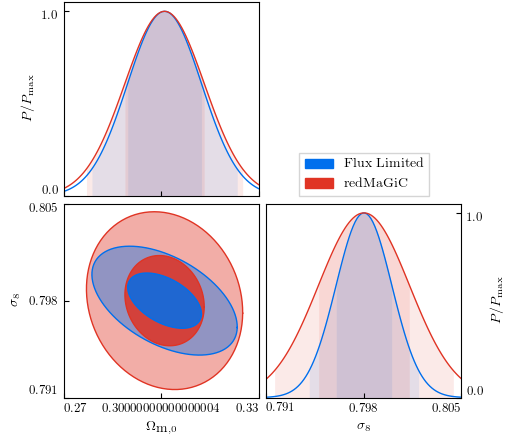

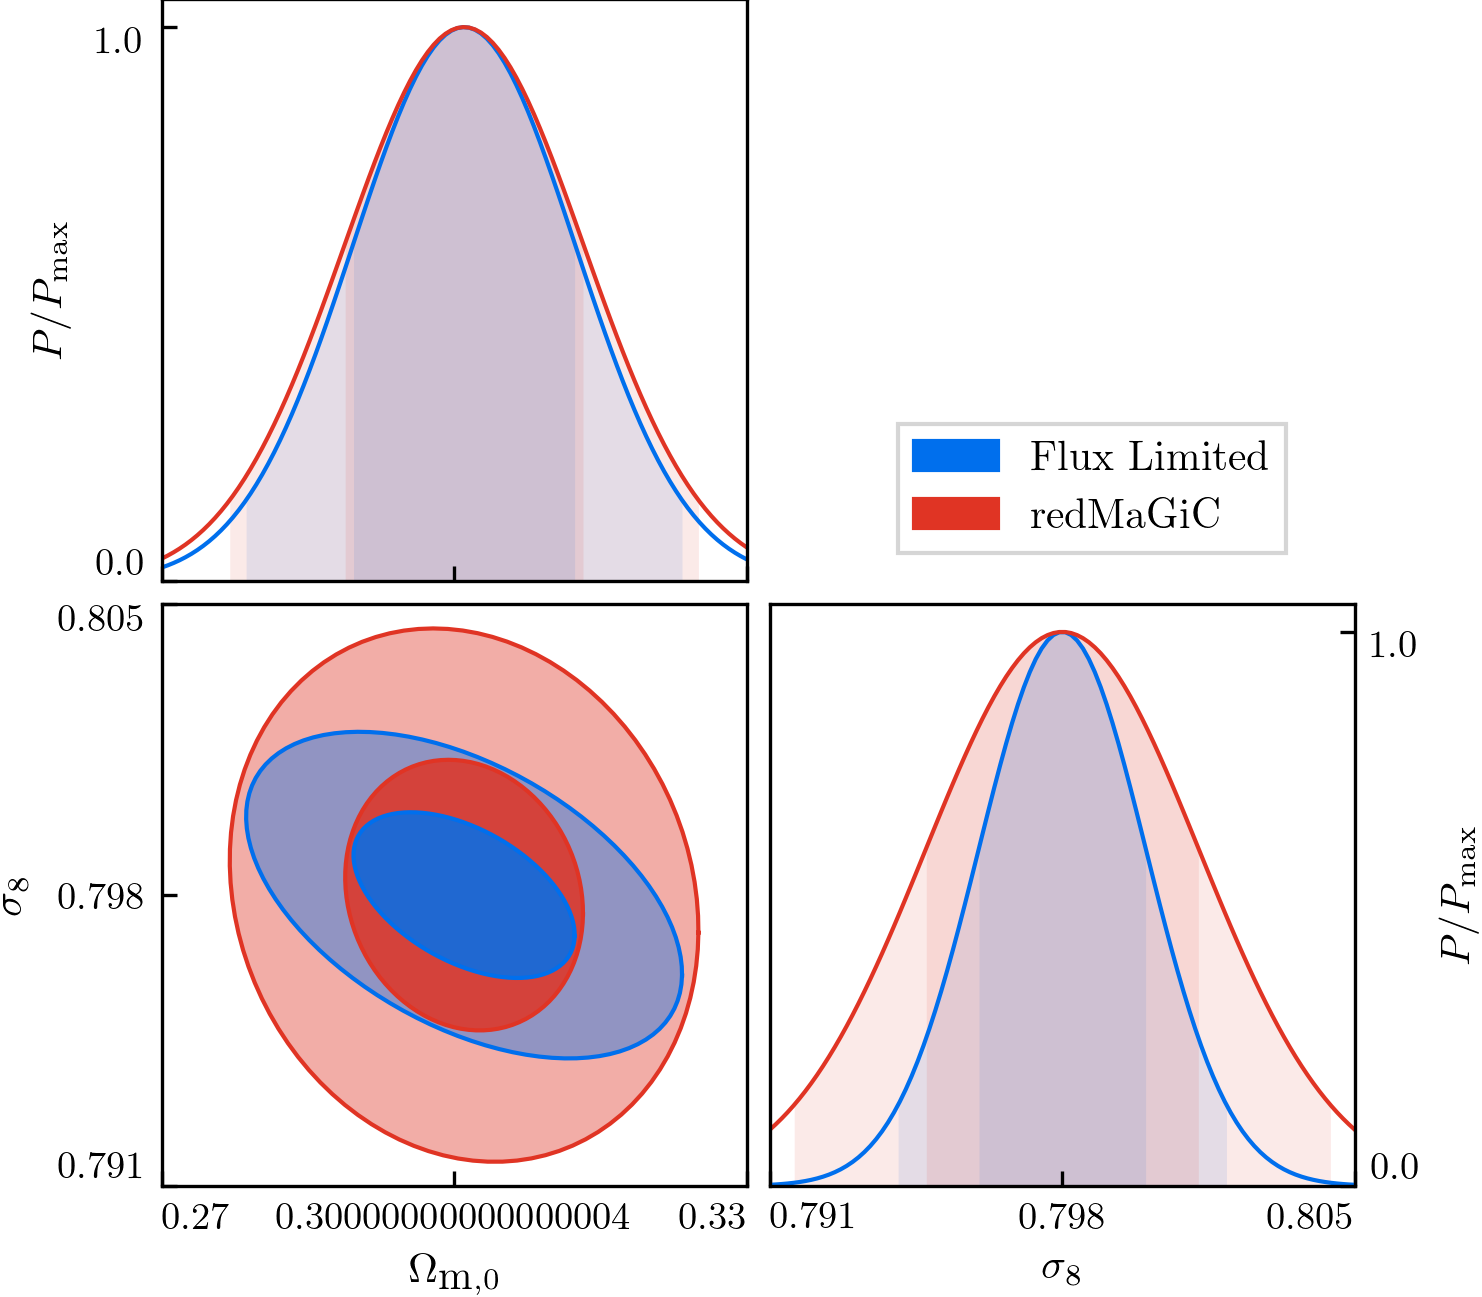

In [51]:
fisher_2 = fm.fisher_matrix( fisher_matrix=matrix_1, fiducial = fiducial, param_names=param_names )
fisher_1 = fm.fisher_matrix( fisher_matrix=matrix_2, fiducial = fiducial, param_names=param_names )
fisher_2.name = 'redMaGiC'
fisher_1.name = 'Flux Limited'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher_1,fisher_2])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('FL_and_RM.pdf', dpi=100)
fisher_plotter.export('FL_and_RM.png', dpi=100)
IPython.display.Image(filename='FL_and_RM.png',unconfined=True)

In [52]:
print fisher_1.get_confidence_bounds( confidence_level=0.68 )
print fisher_1.get_confidence_bounds( confidence_level=0.95 )

print fisher_2.get_confidence_bounds( confidence_level=0.68 )
print fisher_2.get_confidence_bounds( confidence_level=0.95 )

[0.0113441  0.00199367]
[0.02235794 0.0039293 ]
[0.01219611 0.00325567]
[0.02403714 0.00641655]


##### Same plot as above with free photo-z parameters and realistic priors

Let's adopt $\sigma(z_b) = \sigma(\sigma_{z,0}) = 0.5 \times \sigma_{z,0}$.

In [53]:
alpha = 0.5

#prior_rm = alpha*sig_rm
#prior_fl = alpha*sig_fl

prior_rm = 0.006
prior_fl = 0.013

inv_sq_prior_rm = 1.0/(prior_rm**2.0)
inv_sq_prior_fl = 1.0/(prior_fl**2.0)

Fisher_rm_pr = np.copy(Fisher_rm_free)
Fisher_fl_pr = np.copy(Fisher_fl_free)

Fisher_rm_pr[3,3] = Fisher_rm_pr[3,3] + inv_sq_prior_rm
Fisher_rm_pr[4,4] = Fisher_rm_pr[4,4] + inv_sq_prior_rm

Fisher_fl_pr[3,3] = Fisher_fl_pr[3,3] + inv_sq_prior_fl
Fisher_fl_pr[4,4] = Fisher_fl_pr[4,4] + inv_sq_prior_fl

# marginalize 
Fisher_rm_pr_marg = marg(Fisher_rm_pr)
Fisher_fl_pr_marg = marg(Fisher_fl_pr) 

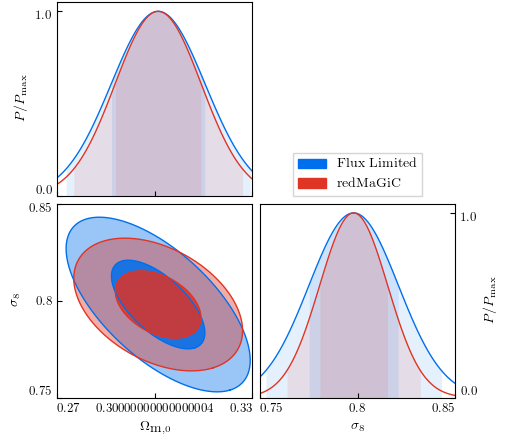

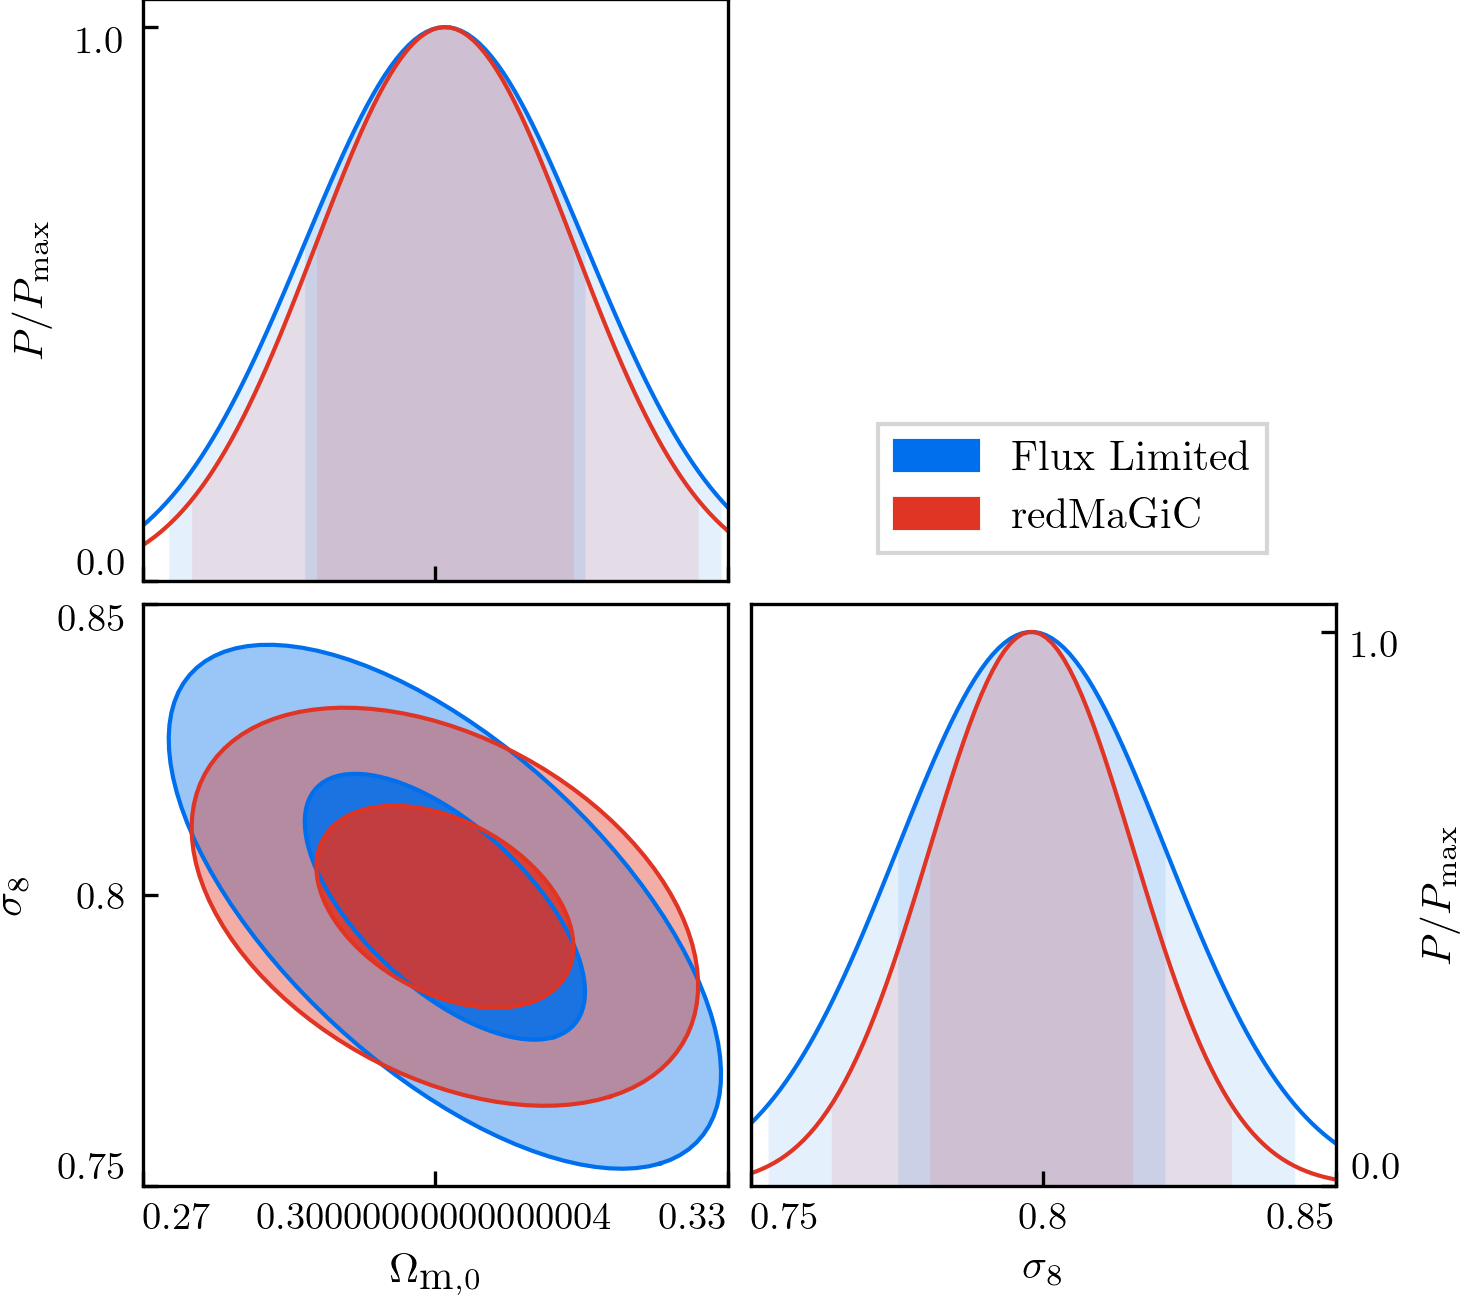

In [54]:
fisher_4 = fm.fisher_matrix( fisher_matrix=Fisher_rm_pr_marg, fiducial = fiducial, param_names=param_names )
fisher_3 = fm.fisher_matrix( fisher_matrix=Fisher_fl_pr_marg, fiducial = fiducial, param_names=param_names )
fisher_4.name = 'redMaGiC'
fisher_3.name = 'Flux Limited'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher_3,fisher_4])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('FL_and_RM_priors.pdf', dpi=100)
fisher_plotter.export('FL_and_RM_priors.png', dpi=100)
IPython.display.Image(filename='FL_and_RM_priors.png',unconfined=True)

In [55]:
print fisher_3.get_confidence_bounds( confidence_level=0.68 )
print fisher_3.get_confidence_bounds( confidence_level=0.95 )

print fisher_4.get_confidence_bounds( confidence_level=0.68 )
print fisher_4.get_confidence_bounds( confidence_level=0.95 )

[0.01437404 0.02284605]
[0.02832961 0.04502698]
[0.01318081 0.01735716]
[0.02597788 0.034209  ]


#### Dependence on the bin size

We have worked above in a fixes bin of size $z \in [0.4,0.6]$. Let's explore the dependence on the bin size, by exploring three binning schemes:

- Thin, $z \in [0.45,0.55]$.

- Normal, $z \in [0.40, 0.60]$.

- Wide, $z \in [0.30, 0.70]$.

We explore how important (we'll see how we are going to adress this) is the size of the bin as a function of the photometric uncertainty, $\sigma_{z,0}$


- First plot:

Angular power spectrum for $\ell = 200$ as a function of $\sigma_{z,0}$ for the three above bin sizes.

In [56]:
sig_z_arr = np.linspace(0.01, 0.1, 300)
size_sig_z = np.size(sig_z_arr)

# ===================================================================
# ===================================================================
# Initialize 
C_l_arr = np.zeros(size_sig_z) # "Normal" bin size: z in [0.40,0.60]
C_l_wide = np.zeros(size_sig_z) # Wide bin: z in [0.30,0.70]
C_l_narrow = np.zeros(size_sig_z) # Narrow bin: z in [0.45,0.55]
# ===================================================================
# ===================================================================
ell_spec = 200

for i in range(size_sig_z):
    sig_z = sig_z_arr[i]
    C_l_arr[i] = APS_specif(z_i, z_f, sig_z, z_bias, bias, Omega_m, sig_8, ell_spec)
    C_l_wide[i] = APS_specif(0.30, 0.70, sig_z, z_bias, bias, Omega_m, sig_8, ell_spec)
    C_l_narrow[i] = APS_specif(0.45, 0.55, sig_z, z_bias, bias, Omega_m, sig_8, ell_spec)

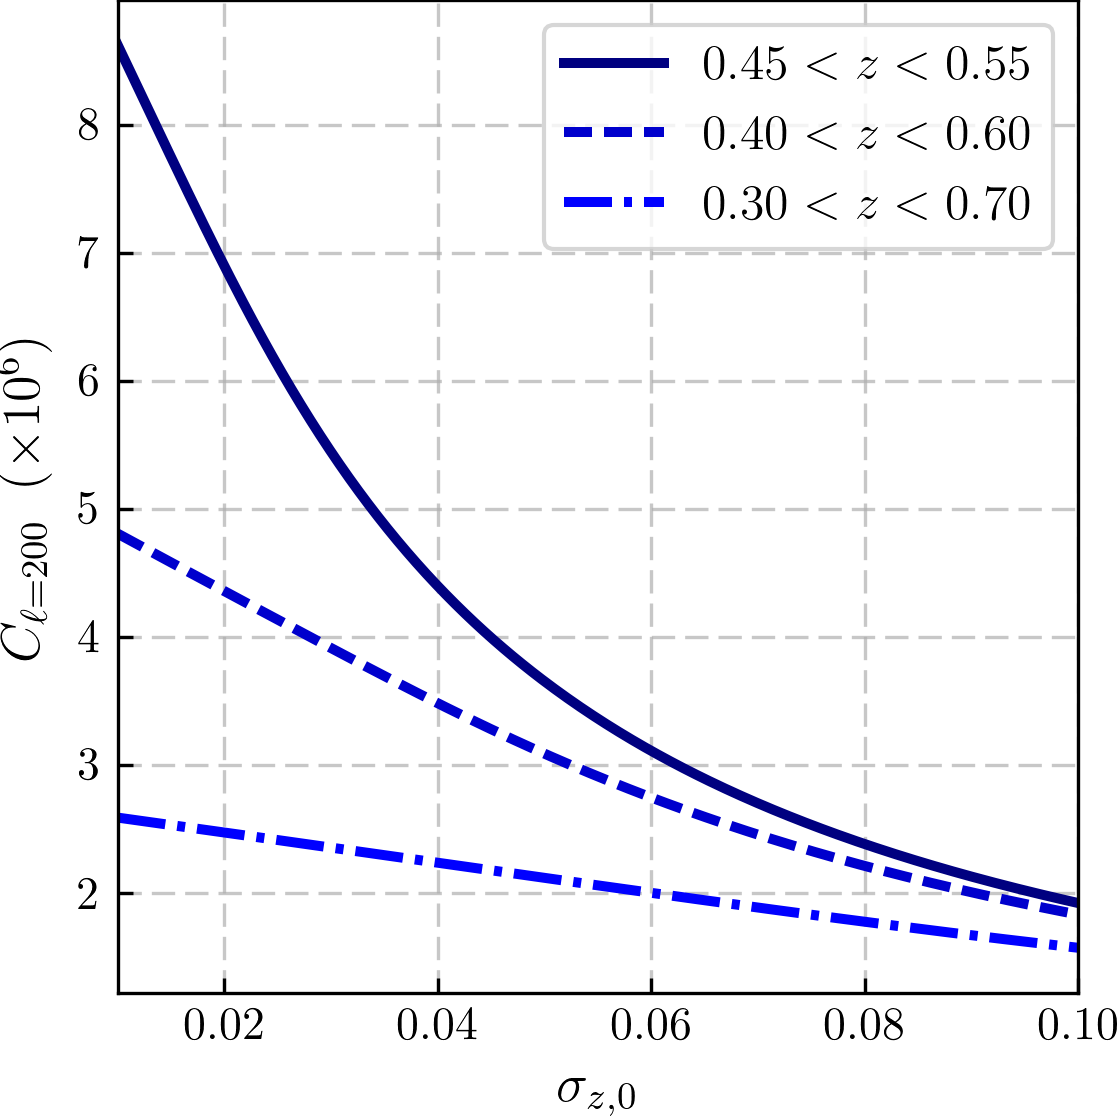

In [57]:
fig = plt.figure(figsize = (4.0,4.0))
plt.plot(sig_z_arr,C_l_narrow*1e6, c='navy',linewidth=2.4, label='$0.45<z<0.55$')
plt.plot(sig_z_arr,C_l_arr*1e6, c='mediumblue', ls = '--',linewidth=2.4, label='$0.40<z<0.60$' )
plt.plot(sig_z_arr,C_l_wide*1e6, c='blue', ls='-.',linewidth=2.4, label='$0.30<z<0.70$')

plt.grid(ls='--', alpha=0.7)
plt.xlim(0.01,0.1)
plt.tick_params(axis='both', labelsize=11)


plt.legend(frameon=True, loc='upper right', fontsize=12)
plt.xlabel('$\sigma_{z,0}$', fontsize=13);plt.ylabel(r'$C_{\ell=200}\,\,\, (\times 10^{6})$ ', fontsize=13)
plt.tight_layout()
plt.savefig('bin_sig_compar.pdf')
plt.show()

Now plot the figure of merit as a function of $\sigma_{z,0}$ and for size always:

\begin{equation}
N_g = 10^7 \frac{\delta z}{0.2}
\end{equation}

So, in the case of narrow bin:

\begin{equation}
N_g = 10^7 \frac{0.1}{0.2} = 5 \times 10^6
\end{equation}

and the wide bin: 

\begin{equation}
N_g = 10^7 \frac{0.4}{0.2} = 2 \times 10^7
\end{equation}

And let's use fixed photo-$z$ parameters.

In [58]:
sig_z_arr = np.linspace(0.01, 0.1, 100)
size_sig_z = np.size(sig_z_arr)
# Sample sizes of the bins
N_g_stand = 1.0e7 #Standard bin
N_g_narrow = 5.0e6 #Narrow bin
N_g_wide = 2.0e7 #Wide bin
# =========================================================
# =========================================================
# Initialize
FoM_stand = np.zeros(size_sig_z) #standsrd bin
FoM_narrow = np.zeros(size_sig_z) #Narrow bin
FoM_wide = np.zeros(size_sig_z) #Wide bin
# =========================================================
# =========================================================
inv_sq_prior = 1.0e35

for i in range(size_sig_z):
    sig_z = sig_z_arr[i]
    # ==========================================================
    # ==========================================================
    #Free fisher matrices for the three cases
    Fish_stand = FSB(z_i,z_f,sig_z,z_bias,bias,f_sky,N_g_stand)
    Fish_narrow = FSB(0.45,0.55,sig_z,z_bias,bias,f_sky,N_g_narrow)
    Fish_wide = FSB(0.30,0.70,sig_z,z_bias,bias,f_sky,N_g_wide) 
    # ==========================================================
    # ==========================================================
    # Add the priors - fixed case here
    Fish_stand[3,3] = Fish_stand[3,3] + inv_sq_prior
    Fish_stand[4,4] = Fish_stand[4,4] + inv_sq_prior
    
    Fish_narrow[3,3] = Fish_narrow[3,3] + inv_sq_prior
    Fish_narrow[4,4] = Fish_narrow[4,4] + inv_sq_prior
    
    Fish_wide[3,3] = Fish_wide[3,3] + inv_sq_prior
    Fish_wide[4,4] = Fish_wide[4,4] + inv_sq_prior
    # ===========================================================
    # ===========================================================
    # Marginalize
    Fish_stand_marg = marg(Fish_stand)
    Fish_narrow_marg = marg(Fish_narrow) 
    Fish_wide_marg = marg(Fish_wide)
    # ==========================================================
    # ==========================================================
    # Calculate 
    
    FoM_stand[i] = np.sqrt(np.linalg.det(Fish_stand_marg))
    FoM_narrow[i] = np.sqrt(np.linalg.det(Fish_narrow_marg))
    FoM_wide[i] = np.sqrt(np.linalg.det(Fish_wide_marg))
    # ==========================================================
    # ==========================================================

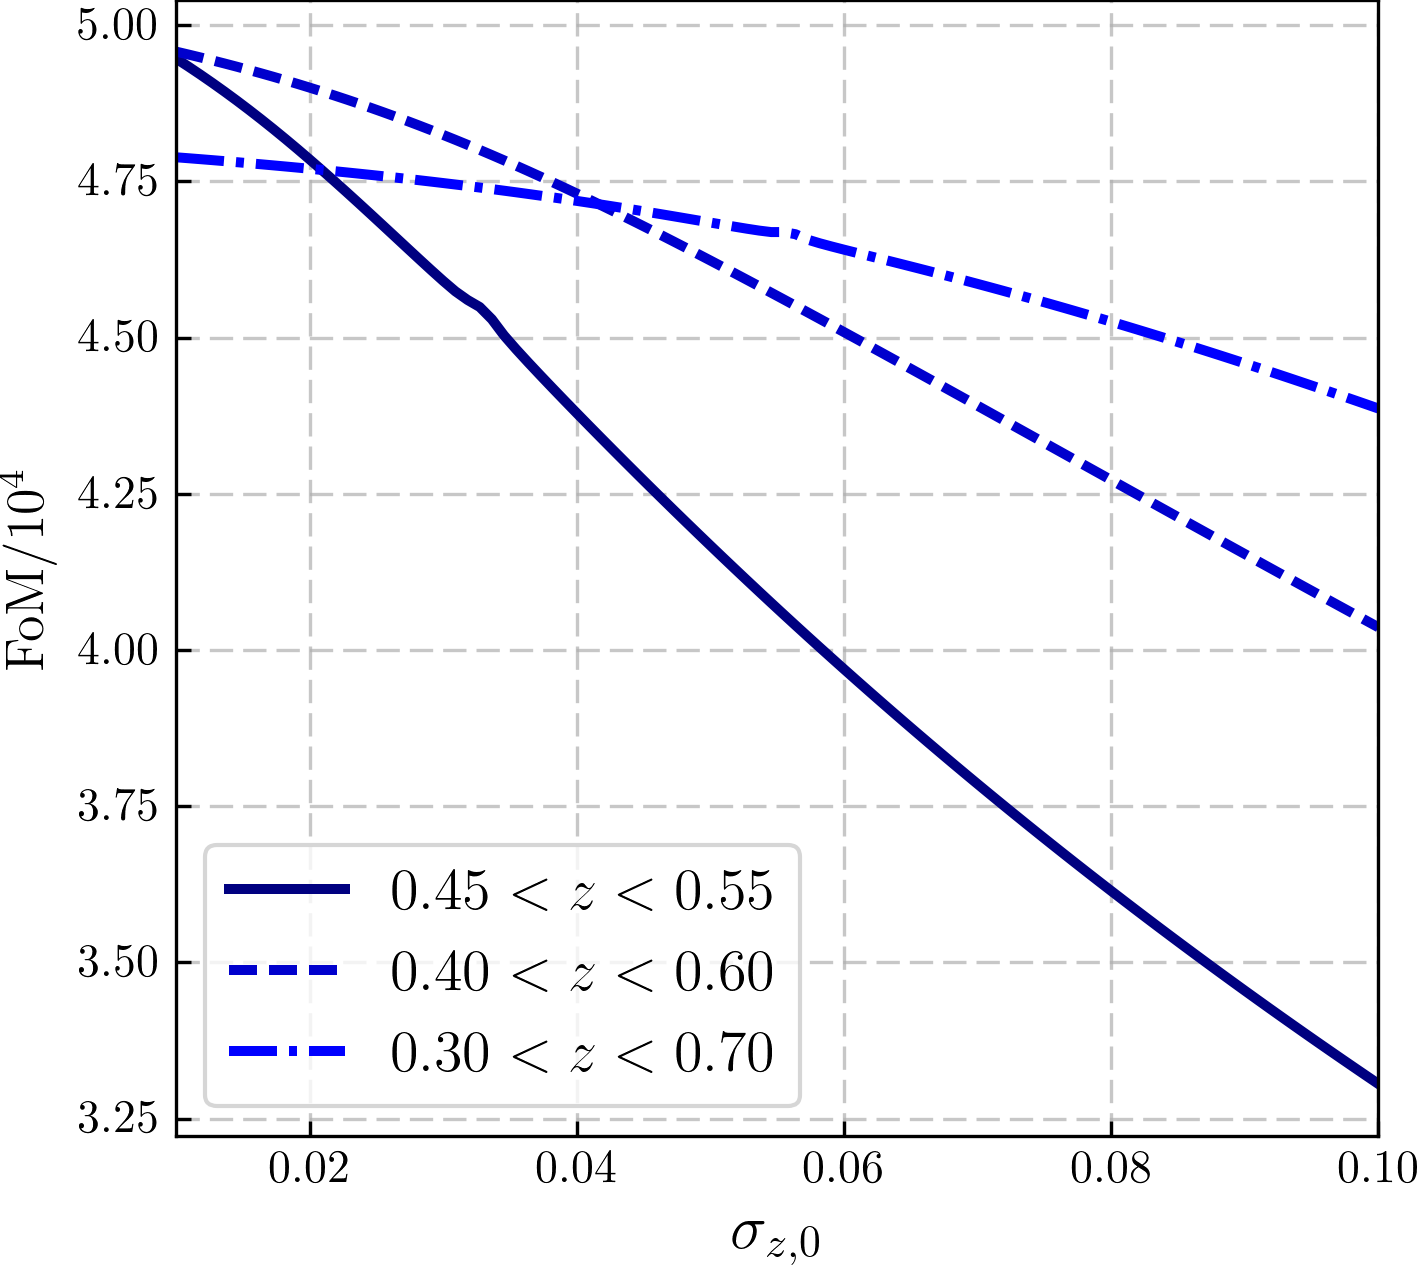

In [85]:
fig = plt.figure(figsize = (5.0,4.5))
plt.plot(sig_z_arr, FoM_narrow/1e4, c='navy',linewidth=2.4, label='$0.45<z<0.55$')
plt.plot(sig_z_arr, FoM_stand/1e4, c='mediumblue', ls = '--',linewidth=2.4, label='$0.40<z<0.60$' )
plt.plot(sig_z_arr, FoM_wide/1e4, c='blue', ls='-.',linewidth=2.4, label='$0.30<z<0.70$')

plt.grid(ls='--', alpha=0.7)
plt.xlim(0.01,0.1)
plt.tick_params(axis='both', labelsize=11)


plt.legend(frameon=True, loc='lower left', fontsize=14)
plt.xlabel('$\sigma_{z,0}$', fontsize=15);plt.ylabel(r'FoM$/10^4$', fontsize=13)
plt.tight_layout()
plt.savefig('bin_sig_compar.pdf')
plt.show()

Finally, we will explore the FoM for some specific samples as afunction of bin size.

Again, we define each sample by its size, $N_g$ and $\sigma_{z,0}$. We define the $N_g$ in the standard bin $z \in [0.4,0.6]$ and $\delta z = 0.2$.

For the sample size in the other bin configurations:

\begin{equation}
N_g' = N_g \times \frac{\delta z}{0.2}
\end{equation}

Each bin is always centered at $z = 0.5$.

In [73]:
delta_z = np.linspace(0.05,0.40,50)
z_i_tem = 0.5 - delta_z/2.0
z_f_tem = 0.5 + delta_z/2.0

# =================================================
# =================================================
# Define the sample characteristics for some specific samples in the bin [0.4,0.6]

N_g_1, sig_z_1 = 1.0e7, 0.01 #redMaGiC - like 
N_g_2, sig_z_2 = 1.0e7, 0.04 #Flux-limited like
N_g_3, sig_z_3 = 1.0e7, 0.08 #A third sample
# =================================================
# =================================================

FoM_1 = np.zeros(len(delta_z))
FoM_2 = np.zeros(len(delta_z))
FoM_3 = np.zeros(len(delta_z))

for i in range (len(delta_z)):
    z_i = z_i_tem[i]
    z_f = z_f_tem[i]
    d_z = delta_z[i]
    N_g_1_t = N_g_1*(d_z/0.2)
    N_g_2_t = N_g_2*(d_z/0.2)
    N_g_3_t = N_g_3*(d_z/0.2)
    # ==================================================
    # ==================================================
    # Calculate the Fisher matrices - free
    
    Fish_1 = FSB(z_i,z_f,sig_z_1,z_bias,bias,f_sky,N_g_1)
    Fish_2 = FSB(z_i,z_f,sig_z_2,z_bias,bias,f_sky,N_g_2)
    Fish_3 = FSB(z_i,z_f,sig_z_3,z_bias,bias,f_sky,N_g_3)
    
    # ===================================================
    # ===================================================
    # Adding prior
    
    Fish_1[3,3] = Fish_1[3,3] + inv_sq_prior
    Fish_1[4,4] = Fish_1[4,4] + inv_sq_prior
    
    Fish_2[3,3] = Fish_2[3,3] + inv_sq_prior
    Fish_2[4,4] = Fish_2[4,4] + inv_sq_prior
    
    Fish_3[3,3] = Fish_3[3,3] + inv_sq_prior
    Fish_3[4,4] = Fish_3[4,4] + inv_sq_prior
    
    # ===================================================
    # ===================================================
    # Marginalize 
    
    Fish_1_marg = marg(Fish_1)
    Fish_2_marg = marg(Fish_2)
    Fish_3_marg = marg(Fish_3)
        
    # ===================================================
    # Calculate figures of merit
    
    FoM_1[i] = np.sqrt(np.linalg.det(Fish_1_marg))
    FoM_2[i] = np.sqrt(np.linalg.det(Fish_2_marg))
    FoM_3[i] = np.sqrt(np.linalg.det(Fish_3_marg))    

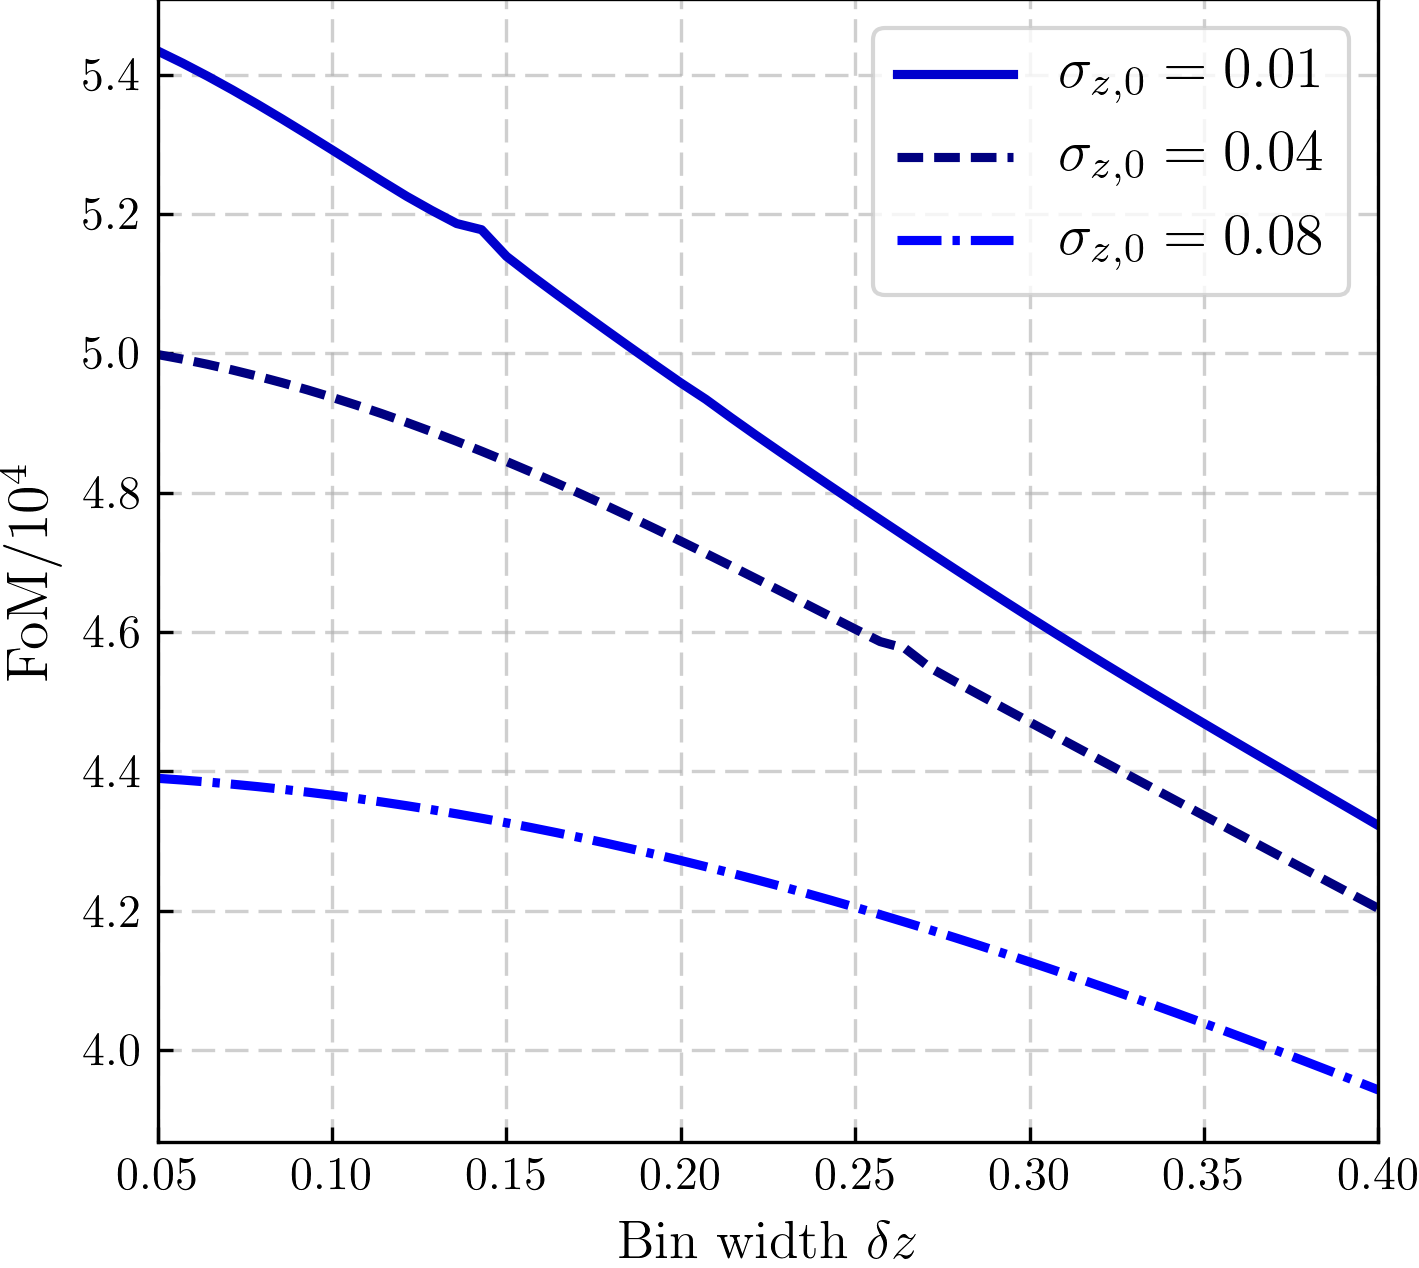

In [87]:
fig = plt.figure(figsize = (5.0,4.5))

plt.plot(delta_z, FoM_1/1.0e4, color='mediumblue', linewidth=2.2, label=r'$\sigma_{z,0} = 0.01$')
plt.plot(delta_z, FoM_2/1e4, color='navy',ls = '--', linewidth=2.2, label=r'$\sigma_{z,0} = 0.04$')
plt.plot(delta_z, FoM_3/1e4, color='blue', ls = '-.', linewidth=2.2, label=r'$\sigma_{z,0} = 0.08$')
plt.grid(ls='--', alpha=0.6)


plt.legend(frameon=True, loc='upper right', fontsize=14)
plt.tick_params(axis='both', labelsize=11)

plt.xlabel('Bin width $\delta z$', fontsize=13)
plt.ylabel(r'FoM$/10^4$', fontsize=14)
plt.xlim(0.05,0.40)

plt.tight_layout()
plt.savefig('FoM_size.pdf')
plt.show()

### Good Plots of specific sample FoMs as function of priors


I will make some nice plots here, I'll show both $\sigma(\sigma_{z,0})/\sigma_{z,0}$ and $N_g$.

First I select four characteristic samples:

For the prior range I adopt:

\begin{equation}
\frac{\sigma(\sigma_{z,0})}{\sigma_{z,0}} \in [10^{-3},10^0]
\end{equation}

I plot the figures of merit as:

\begin{equation}
\frac{FoM}{FoM_{RM,fix}},
\end{equation}

I.e. I normalize everything according toe the fixed photo-z's redMaGiC sample.

Priors:
\begin{equation}
\Delta z_b = \frac{\sigma_{z}}{\sqrt{N_{spec}}} = \frac{\sigma_{z,0}(1+z)}{\sqrt{N_{spec}}}
\end{equation}

and 

\begin{equation}
\Delta \sigma_{z} = \frac{\sigma_{z}}{\sqrt{2 N_{spec}}} \Rightarrow  \frac{\sigma_{z,0}(1+z)}{\sqrt{2N_{spec}}}
\end{equation}

If $\alpha = \frac{\Delta \sigma_{z,0}}{\sigma_{z,0}}$, then we can easily solve and find: $ N_{spec} = \frac{1}{2\alpha^2}$.


So, note that $\Delta z_b = \sqrt{2}(1+z)\Delta \sigma_{z,0}$

First I select the following four samples:

\begin{eqnarray}
N_g &=& 1.1\times 10^6, \quad \sigma_{z,0} = 0.014 \quad (redMaGiC) \\
N_g &=& 1.0\times 10^7, \quad \sigma_{z,0} = 0.04 \\
N_g &=& 1.5 \times 10^7, \quad \sigma_{z,0} = 0.06 \\ 
N_g &=& 2.8\times 10^7, \quad \sigma_{z,0} = 0.08 \quad (flux \,\,limited)
\end{eqnarray}

In [62]:
#==================================================================
#==================================================================
#parameters of the bin - just to be sure
z_i = 0.4
z_f = 0.6
z_m = 0.5*(z_i + z_f)
bias = 1.0 + z_m  #Common galaxy bias
z_bias = 0.0
#=================================================================
#=================================================================

#==================================================================
# Define the array in alpha
alpha_lin = np.linspace(-4.0,0.0,300)
alpha = 10.0**alpha_lin

In [69]:
# Define the samples - N_g and sig_z,0
# ============================================================
# ============================================================
N_rm, sig_rm = 1.1e6, 0.014
N_fl, sig_fl = 2.8e7, 0.08
N_1, sig_1 = 1.0e7, 0.04
N_2, sig_2 = 1.5e7, 0.06

# ============================================================
# ============================================================
# Calculate the free fisher matrices in the above cases - i.e. without any priors

Fisher_rm_free = FSB(z_i,z_f,sig_rm,z_bias,bias,f_sky,N_rm)
Fisher_fl_free = FSB(z_i,z_f,sig_fl,z_bias,bias,f_sky,N_fl)
Fisher_1_free = FSB(z_i,z_f,sig_1,z_bias,bias,f_sky,N_1)
Fisher_2_free = FSB(z_i,z_f,sig_2,z_bias,bias,f_sky,N_2)


# ==========================================================
# Calculate the priors - and their inverses - in all cases
# These will be arrays

prior_rm = alpha*sig_rm
prior_fl = alpha*sig_fl
prior_1 = alpha*sig_1
prior_2 = alpha*sig_2

#Inverses of the squares of the priors
inv_sq_prior_rm  = 1.0/(prior_rm**2.0)
inv_sq_prior_fl = 1.0/(prior_fl**2.0)
inv_sq_prior_1 = 1.0/(prior_1**2.0)
inv_sq_prior_2 = 1.0/(prior_2**2.0)

# =========================================================
# =========================================================

# FoMs will also be arrays - initialize them
FoM_rm = np.zeros(len(alpha))
FoM_fl = np.zeros(len(alpha))
FoM_1 = np.zeros(len(alpha))
FoM_2 = np.zeros(len(alpha))



# ============================================================
# Calculate now 

for i in range(len(alpha)):
    Fisher_rm = np.copy(Fisher_rm_free)
    Fisher_fl = np.copy(Fisher_fl_free)
    Fisher_1 = np.copy(Fisher_1_free)
    Fisher_2 = np.copy(Fisher_2_free)
    
    # ============================================
    # ============================================
    inv_prior_rm = inv_sq_prior_rm[i]
    inv_prior_fl = inv_sq_prior_fl[i]
    inv_prior_1 = inv_sq_prior_1[i]
    inv_prior_2 = inv_sq_prior_2[i]
    
    
    # =============================================
    # =============================================
    # Add the priors
    Fisher_rm[3,3] = Fisher_rm[3,3] + inv_prior_rm
    Fisher_rm[4,4] = Fisher_rm[4,4] + inv_prior_rm
    
    Fisher_fl[3,3] = Fisher_fl[3,3] + inv_prior_fl
    Fisher_fl[4,4] = Fisher_fl[4,4] + inv_prior_fl
    
    Fisher_1[3,3] = Fisher_1[3,3] + inv_prior_1
    Fisher_1[4,4] = Fisher_1[4,4] + inv_prior_1
    
    Fisher_2[3,3] = Fisher_2[3,3] + inv_prior_2
    Fisher_2[4,4] = Fisher_2[4,4] + inv_prior_2
    # ===============================================
    # ===============================================
    # Marginalize 
    Fish_rm_marg = marg(Fisher_rm)
    Fish_fl_marg = marg(Fisher_fl)
    Fish_1_marg = marg(Fisher_1)
    Fish_2_marg = marg(Fisher_2)
    
    # ======================================================
    # ======================================================
    # Calculate the FoMs
    
    FoM_rm[i] = np.sqrt(np.linalg.det(Fish_rm_marg))
    FoM_fl[i] = np.sqrt(np.linalg.det(Fish_fl_marg))
    FoM_1[i] = np.sqrt(np.linalg.det(Fish_1_marg))
    FoM_2[i] = np.sqrt(np.linalg.det(Fish_2_marg))
    

# ===========================================================================
# ===========================================================================

# Normalize to the FoM of the redMaGiC sample
FoM_rm_temp = FoM_rm
FoM_rm = FoM_rm/FoM_rm_fix
FoM_fl = FoM_fl/FoM_rm_fix
FoM_1 = FoM_1/FoM_rm_fix
FoM_2 = FoM_2/FoM_rm_fix


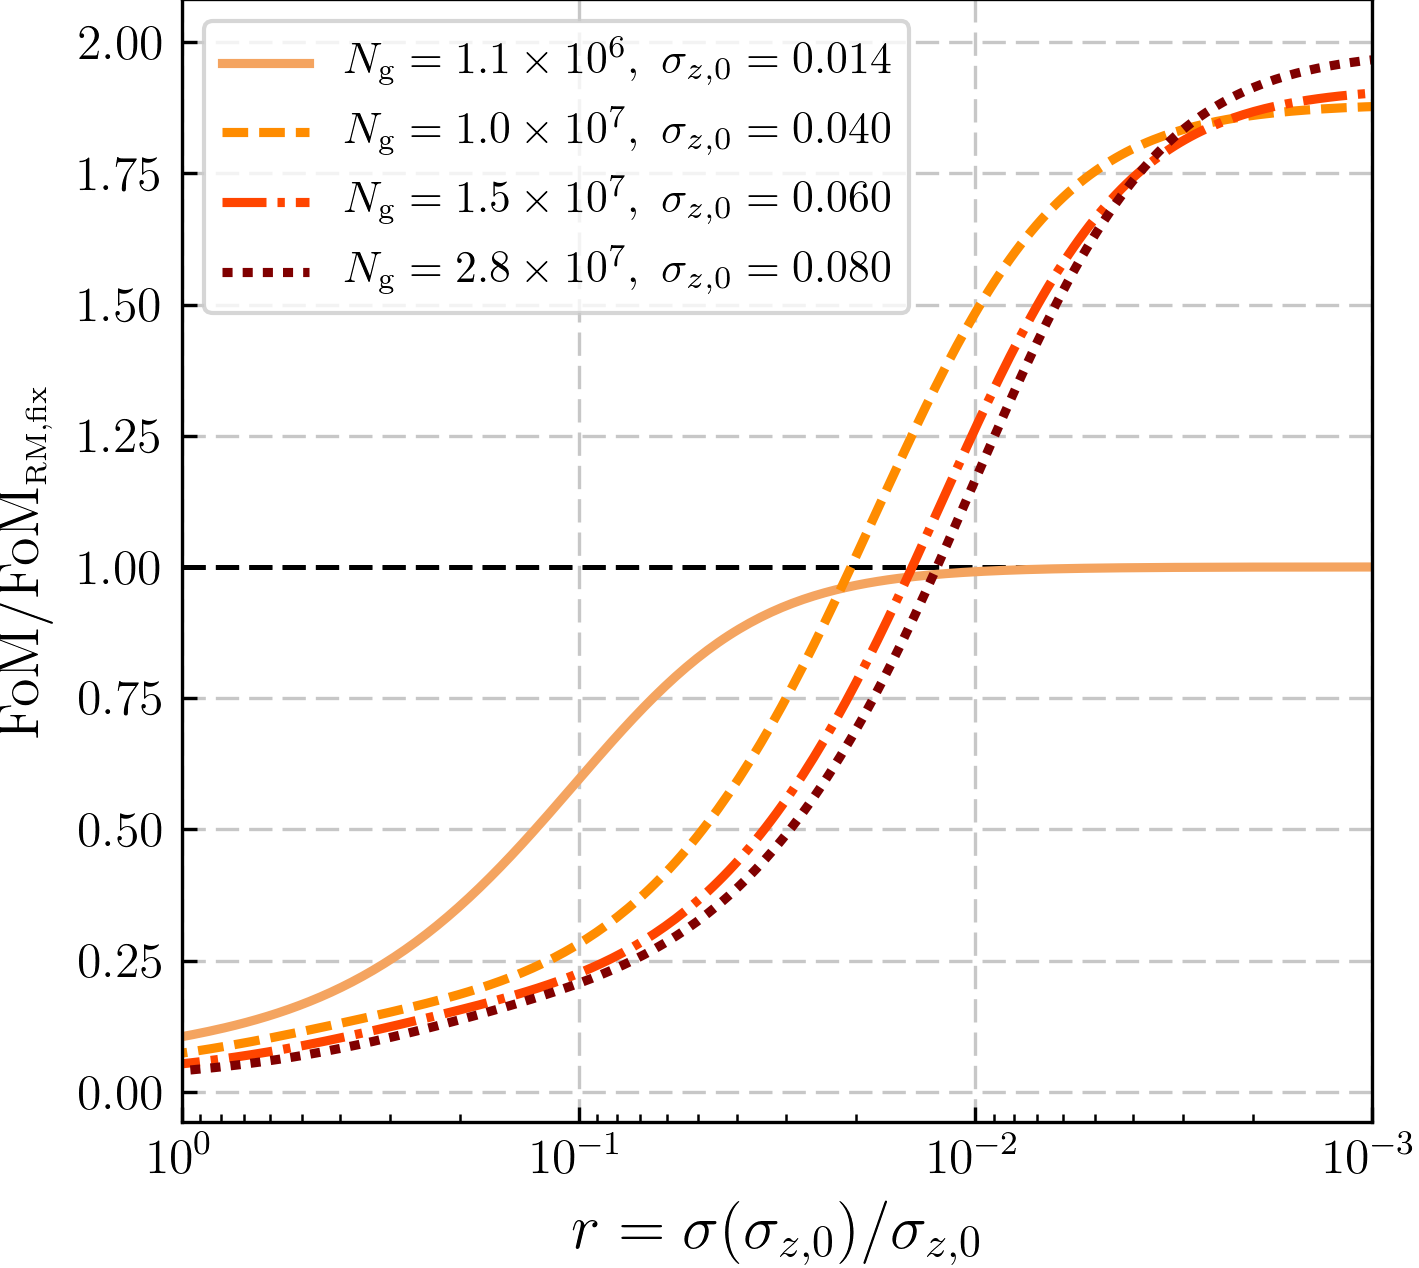

In [70]:
fig = plt.figure(figsize = (5.0,4.5))


plt.plot(alpha, FoM_rm, linewidth=2.2, c='sandybrown', label=r'$N_{\mbox{\scriptsize{g}}}=1.1 \times 10^6, \,\, \sigma_{z,0} = 0.014$')
plt.plot(alpha, FoM_1, linewidth=2.2, c='darkorange',ls='--', label=r'$N_{\mbox{\scriptsize{g}}}=1.0 \times 10^7, \,\, \sigma_{z,0} = 0.040$')
plt.plot(alpha, FoM_2, linewidth=2.2, c='orangered', ls='-.', label=r'$N_{\mbox{\scriptsize{g}}}=1.5 \times 10^7, \,\, \sigma_{z,0} = 0.060$')
plt.plot(alpha, FoM_fl, linewidth=2.2, c='maroon', ls=':', label=r'$N_{\mbox{\scriptsize{g}}}=2.8 \times 10^7, \,\, \sigma_{z,0} = 0.080$')


plt.hlines(1.0,1,1e-3, color='k', linestyle='--', linewidth= 1.2)

plt.ylabel('FoM/FoM$_{\scriptsize{\mbox{RM,fix}}}$',fontsize=14)
plt.xlabel(r'$r = \sigma(\sigma_{z,0})/\sigma_{z,0}$',fontsize=15)
plt.tick_params(axis='both', labelsize=12)


plt.grid(ls='--', alpha=0.7)

plt.legend(frameon=True, loc='upper left', fontsize=10.5)


plt.xscale('log');plt.xlim(1.0,1e-3)

plt.tight_layout()

plt.savefig('FoM_priors_1.pdf')
plt.show()

Now, same plot as above, but for samples closer to redMaGiC

Select the following samples:

\begin{eqnarray}
N_g &=& 1.1\times 10^6, \quad \sigma_{z,0} = 0.014\\
N_g &=& 2\times 10^6, \quad \sigma_{z,0} = 0.016\\
N_g &=& 4 \times 10^6, \quad \sigma_{z,0} = 0.018\\
N_g &=& 5 \times 10^6, \quad \sigma_{z,0} = 0.020
\end{eqnarray}

In [71]:
# Define the samples
# =================================
N_3, sig_3 = 2.0e6, 0.016
N_4, sig_4 = 4.0e6, 0.018
N_5, sig_5 = 5.0e6, 0.020

# ============================================================
# ============================================================
# Calculate the free fisher matrices in the above cases - i.e. without any priors

Fisher_3_free = FSB(z_i,z_f,sig_3,z_bias,bias,f_sky,N_3)
Fisher_4_free = FSB(z_i,z_f,sig_4,z_bias,bias,f_sky,N_4)
Fisher_5_free = FSB(z_i,z_f,sig_5,z_bias,bias,f_sky,N_5)


# ==========================================================
# Calculate the priors - and their inverses - in all cases
# These will be arrays

prior_3 = alpha*sig_3
prior_4 = alpha*sig_4
prior_5 = alpha*sig_5


#Inverses of the squares of the priors
inv_sq_prior_3 = 1.0/(prior_3**2.0)
inv_sq_prior_4 = 1.0/(prior_4**2.0)
inv_sq_prior_5 = 1.0/(prior_5**2.0)

# =========================================================
# =========================================================

# FoMs will also be arrays - initialize them
FoM_3 = np.zeros(len(alpha))
FoM_4 = np.zeros(len(alpha))
FoM_5 = np.zeros(len(alpha))

# ============================================================
# Calculate now 

for i in range(len(alpha)):
    Fisher_3 = np.copy(Fisher_3_free)
    Fisher_4 = np.copy(Fisher_4_free)
    Fisher_5 = np.copy(Fisher_5_free)
    
    # ============================================
    # ============================================
    inv_prior_3 = inv_sq_prior_3[i]
    inv_prior_4 = inv_sq_prior_4[i]
    inv_prior_5 = inv_sq_prior_5[i]
    
    
    # =============================================
    # =============================================
    # Add the priors
    Fisher_3[3,3] = Fisher_3[3,3] + inv_prior_3
    Fisher_3[4,4] = Fisher_3[4,4] + inv_prior_3
    
    Fisher_4[3,3] = Fisher_4[3,3] + inv_prior_4
    Fisher_4[4,4] = Fisher_4[4,4] + inv_prior_4
    
    Fisher_5[3,3] = Fisher_5[3,3] + inv_prior_5
    Fisher_5[4,4] = Fisher_5[4,4] + inv_prior_5
    # ===============================================
    # ===============================================
    # Marginalize 
    Fish_3_marg = marg(Fisher_3)
    Fish_4_marg = marg(Fisher_4)
    Fish_5_marg = marg(Fisher_5)
    
    # ======================================================
    # ======================================================
    # Calculate the FoMs
    
    FoM_3[i] = np.sqrt(np.linalg.det(Fish_3_marg))
    FoM_4[i] = np.sqrt(np.linalg.det(Fish_4_marg))
    FoM_5[i] = np.sqrt(np.linalg.det(Fish_5_marg))
    

# ===========================================================================
# ===========================================================================

# Normalize to the FoM of the redMaGiC sample
FoM_rm = FoM_rm_temp/FoM_rm_fix
FoM_3 = FoM_3/FoM_rm_fix
FoM_4 = FoM_4/FoM_rm_fix
FoM_5 = FoM_5/FoM_rm_fix



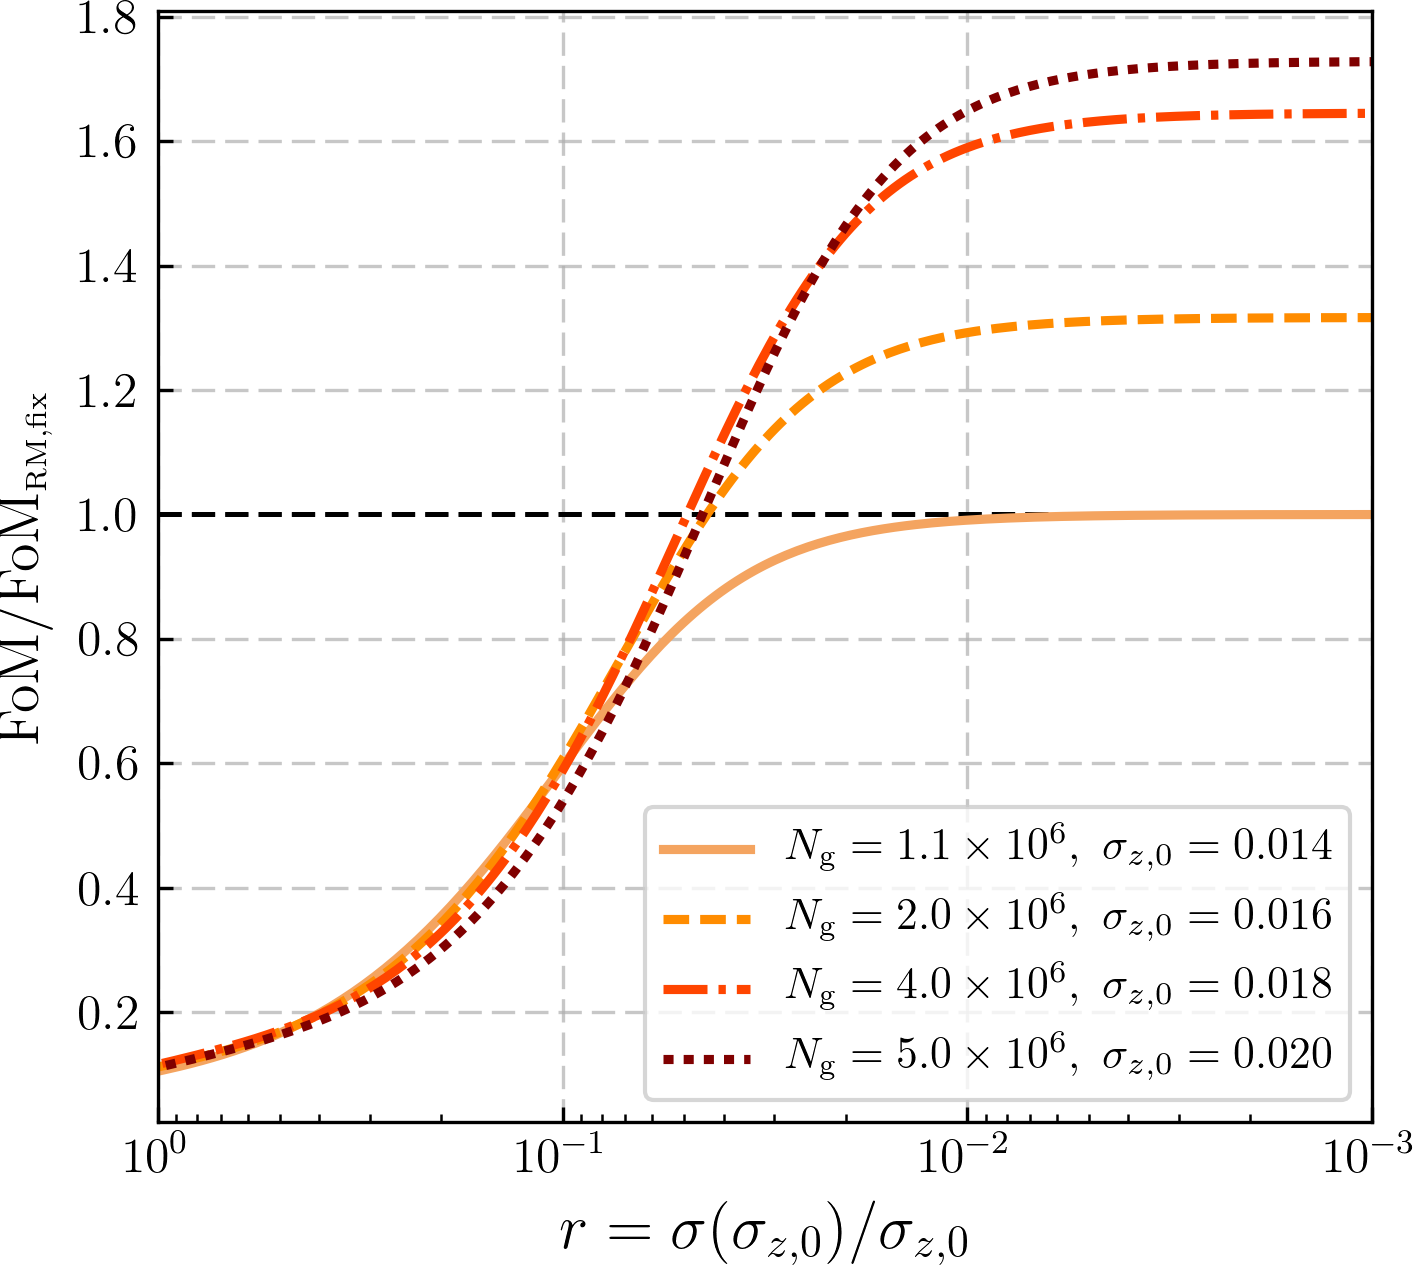

In [72]:
fig = plt.figure(figsize = (5.0,4.5))


plt.plot(alpha, FoM_rm, linewidth=2.2, c='sandybrown', label=r'$N_{\mbox{\scriptsize{g}}}=1.1 \times 10^6, \,\, \sigma_{z,0} = 0.014$')
plt.plot(alpha, FoM_3, linewidth=2.2, c='darkorange',ls='--', label=r'$N_{\mbox{\scriptsize{g}}}= 2.0 \times 10^6, \,\, \sigma_{z,0} = 0.016$')
plt.plot(alpha, FoM_4, linewidth=2.2, c='orangered', ls='-.', label=r'$N_{\mbox{\scriptsize{g}}}= 4.0 \times 10^6, \,\, \sigma_{z,0} = 0.018$')
plt.plot(alpha, FoM_5, linewidth=2.2, c='maroon', ls=':', label=r'$N_{\mbox{\scriptsize{g}}}= 5.0 \times 10^6, \,\, \sigma_{z,0} = 0.020$')


plt.hlines(1.0,1,1e-3, color='k', linestyle='--', linewidth= 1.2)

plt.ylabel('FoM/FoM$_{\scriptsize{\mbox{RM,fix}}}$',fontsize=14)
plt.xlabel(r'$r = \sigma(\sigma_{z,0})/\sigma_{z,0}$',fontsize=15)
plt.tick_params(axis='both', labelsize=12)


plt.grid(ls='--', alpha=0.7)

plt.legend(frameon=True, loc='lower right', fontsize=10.5)


plt.xscale('log');plt.xlim(1.0,1e-3)

plt.tight_layout()

plt.savefig('FoM_priors_2.pdf')
plt.show()